# Sizing & Drawing of Bias Circuits

**Copyright 2024 Simon Dorrer**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0

This sizing script shows the sizing of four different versions of supply-independent self-biased low-current reference circuits. Starting with a simple beta-multiplier circuit and improving it with cascodes and an auxiliary amplifier.

## Packages

In [55]:
# Packages
from pygmid import Lookup as lk
import scipy.constants as sc
import scipy.io as sio
import scipy.integrate as sci
import matplotlib.pyplot as plt
import numpy as np

plt.close("all")
# %matplotlib qt
%matplotlib inline

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 14)

In [56]:
# read table data
# List of parameters: VGS, VDS, VSB, VTH, VDSS, L, W, NFING, ID, GM, GMB, GDS, CGG, CGB, CGD, CGS, CDD, CSS, STH, SFL
lv_nmos = lk('../data/sg13g2_lv_nmos.mat')
lv_pmos = lk('../data/sg13g2_lv_pmos.mat')

## Functions

In [57]:
def round_to(n, um):
  return round(n / um) * um

## Specifications

In [58]:
# Room Temperature
T = 300 # in Kelvin

# Set global voltages
VDD = 1.5
VSS = 0.0
Vcm = VDD / 2

## Version 1 - Beta-Multiplier Reference (BMR)

Drawing

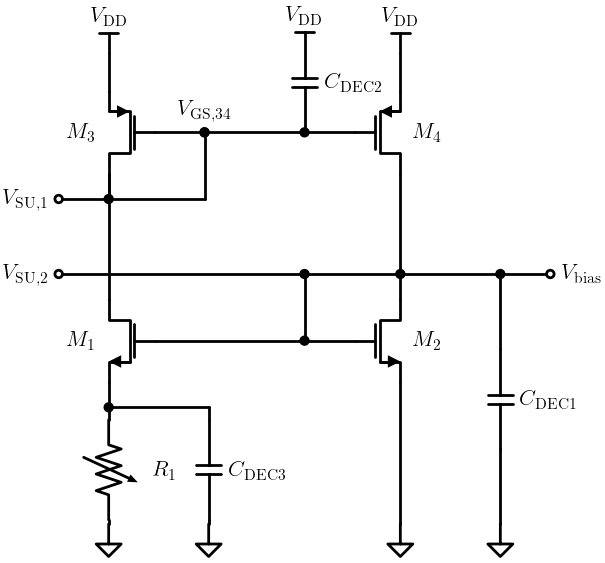

In [59]:
# Draw Bias Circuit v1 without W/L
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=16)
    
    # Vbias
    elm.Dot(open=True).label('$V_\mathrm{bias}$', loc='right', ofst=0.15)
    elm.Line().left().length(1).dot()
    d.push()

    # CDEC1
    elm.Line().down().length(1.5)
    elm.Capacitor().label('$C_\mathrm{DEC1}$', loc='bottom', ofst=0.15).down()
    elm.Line().down().length(1.5)
    gndDot = d.here
    elm.GroundSignal(lead=True)
    d.pop()
    elm.Line().left().length(2)
    biasDot = d.here
    elm.Line().down().length(0.5)

    # M2
    M2 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{2}$', ofst=-1.75).reverse()
    elm.Line().at(M2.source).down().toy(gndDot)
    elm.GroundSignal()
    elm.Line().at(M2.gate).left().length(1).dot()
    M2gate = d.here
    elm.Line().up().toy(biasDot).dot()
    M2gate2 = d.here
    elm.Line().right().tox(biasDot).dot()

    # M4
    elm.Line().up().length(2)
    M4 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{4}$', ofst=-1.75).reverse()
    elm.Line().at(M4.source).up().length(0.75)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M4.gate).left().length(1).dot()

    # CDEC2
    d.push()
    elm.Capacitor().label('$C_\mathrm{DEC2}$', loc='bottom', ofst=0.15).up()
    elm.Vdd(lead=False).label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    d.pop()
    elm.Line().left().length(2).dot()
    elm.Dot(open=False).label('$V_\mathrm{GS,34}$', loc='top', ofst=0.15)
    Vgs34 = d.here

    # M3
    elm.Line().left().length(1)
    M3 = elm.AnalogPFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{3}$', ofst=0.25)
    elm.Line().at(M3.source).up().length(0.75)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M3.drain).down().length(0.5).dot()
    d.push()
    elm.Line().left().length(1)
    elm.Dot(open=True).label('$V_\mathrm{SU,1}$', loc='left', ofst=0.15)
    Vsu1Dot = d.here
    d.pop()
    d.push()
    elm.Line().right().tox(Vgs34)
    elm.Line().up().toy(Vgs34)
    d.pop()

    # M1
    elm.Line().at(M3.drain).down().toy(M2.drain)
    M1 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{1}$', ofst=0.25)
    elm.Line().at(M1.gate).right().tox(M2gate)
    elm.Line().at(M1.source).down().length(0.5).dot()

    # CDEC3
    d.push()
    elm.Line().right().length(2)
    elm.Line().down().length(0.25)
    elm.Capacitor().label('$C_\mathrm{DEC3}$', loc='bottom', ofst=0.15).down()
    elm.Line().down().toy(gndDot)
    elm.GroundSignal()
    d.pop()

    # R1
    elm.Line().down().length(0.25)
    elm.ResistorVarIEEE().label('$R_\mathrm{1}$', loc='bottom', ofst=0.15).down()
    elm.Line().down().toy(gndDot)
    elm.GroundSignal()

    # VSU2
    elm.Line().at(M2gate2).left().tox(Vsu1Dot)
    elm.Dot(open=True).label('$V_\mathrm{SU,2}$', loc='left', ofst=0.15)

    # Save the schematic
    d.save('figures/bias_circuit/bias_circuit_v1_circuit.svg')
    d.save('figures/bias_circuit/bias_circuit_v1_circuit.pdf')

Specifications

In [60]:
# If M1 / M2 of the differential pair in the telescopic stage obey the same "physics" as M2 (similar inversion level and channel length), 
# their transconductances will also be stable over process and temperature.

# Initial guess of L
# The telescopic OTA has a height of 80um, combine these lengths to get a good matching layout.
l_34 = 4 * 10
l_12 = 4 * 10

# The generated reference current equals
Iref = 10e-9
print('Iref =', round(float(Iref) * 1e9, 2), 'nA')
print('total supply current of bias circuit = 2 * Iref =', round(float(2 * Iref) * 1e9, 1), 'nA')

# The core of the circuit consists of two self-biased current mirrors, resulting into the following currents after start-up.
# i_m1 = i_m3 == i_m2 = i_m4 = Iref

# Voltage drop across R_1 at 10nA
# Set V_R for a convenient W/L ratio of M2.
# 5u/40u would be suitable since M8, M9 and M14 in the amplifier core are sized accordingly.
# If V_R is increased, R_1_bias is increased, but gm/ID of M2 is decreased (Vgs_m2 = Vds_m2 increases), decreasing w_1 / w_2. Higher R_1_bias means lower C_1_bias.
# Simulation shows that with increasing V_R (decreasing w_2), gds increases, but PSRR decreases.
# Since in version 2 cascodes for higher gds are used anyway, it is tried to increase PSRR for now.
# On the other hand, gm_m2 ~ gm_m12 of telescopic diff. pair ~ 4.7uS (optional)
V_R = 34.43e-3 # K = 4
print('V_R =', round(float(V_R) * 1e3, 2), 'mV')

# Calculate resistor R_1
R_1_bias = V_R / Iref
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')

Iref = 10.0 nA
total supply current of bias circuit = 2 * Iref = 20.0 nA
V_R = 34.43 mV
R_1_bias = 3.44 MOhm


Look-up

In [61]:
# Sizing of NMOS M2

# According to [Jespers / Murmann] (5.6) or [Carusone] (7.8)
# gm_m2 = 2 / R_1_bias * (1 - np.sqrt(w_2 / w_1))
# Thus, the transconductance of M2 is determined by and geometric ratios only, 
# independent of power-supply voltages, process parameters, temperature, or any other parameters with large variability.
# Not only gm_m2 is stabilized, but all other transconductances are also stabilized since all transistor currents are derived from the same biasing network.

# Transconductance (gm) from gm/ID and ID of M2
# If W1 = K * W2, this formula simplifies to gm_m2 = 2 / R_1_bias * (1 - 1 / np.sqrt(K))
# If K = 4, this formula simplifies to gm_m2 = 1 / R_1_bias
# If K is increased, gm/ID increases and therefore w_1 increases.
# If K is too small, V_R must be decreased resulting into a higher R_1_bias, but at the same time w_2 reduces.
K = 4
gm_m2 = 2 / R_1_bias * (1 - 1 / np.sqrt(K))
print(f"gm_m2 = {round(float(gm_m2) * 1e6, 2)}uS")

# gm/ID of M2
gm_id_m2 = gm_m2 / Iref
print(f"gm_id_m2 = {round(float(gm_id_m2), 2)} S/A")

# Vds,sat of M2
Vds_sat_m2 = 2 / gm_id_m2
print('Vds_sat_m2 =', round(float(Vds_sat_m2), 2), 'V')

# Vgs of M2
Vgs_m2 = lv_nmos.lookupVGS(GM_ID=gm_id_m2, L=l_12, VSB=0)
print('Vgs_m2 =', round(float(Vgs_m2), 2), 'V')

# Vds of M2
# Since M2 is diode connected, Vgs and Vds equal the same.
Vds_m2 = Vgs_m2
if Vds_m2 > Vds_sat_m2: 
  print('Vds_m2 =', round(float(Vds_m2), 2), 'V > Vds_sat_m2 --> M2 operates in saturation (check)')
else:
  print('Vds_m2 =', round(float(Vds_m2), 2), 'V < Vds_sat_m2 --> M2 does NOT operate in saturation!!!')

# Output Conductance (gds) of M2
gm_gds_m2 = lv_nmos.lookup("GM_GDS", L=l_12, VGS=Vgs_m2, VDS=Vds_m2, VSB=0)
gds_m2 = gm_m2 / gm_gds_m2
print(f"gds_m2 = {round(float(gds_m2) * 1e9, 2)}nS (= {round(float(1/gds_m2) * 1e-6, 2)}MOhm)")

# ID/W of M2
id_W_m2 = lv_nmos.lookup("ID_W", L=l_12, VGS=Vgs_m2, VDS=Vds_m2, VSB=0)
w_2 = Iref / id_W_m2
print(f"w_2 = {round(float(w_2), 2)} um ~ {round_to(float(w_2), 0.5)} um (rounded)")

gm_m2 = 0.29uS
gm_id_m2 = 29.04 S/A
Vds_sat_m2 = 0.07 V
Vgs_m2 = 0.11 V
Vds_m2 = 0.11 V > Vds_sat_m2 --> M2 operates in saturation (check)
gds_m2 = 7.52nS (= 133.03MOhm)
w_2 = 5.0 um ~ 5.0 um (rounded)


In [62]:
# Sizing of NMOS M1

# Width of M1
w_1 = K * w_2
print(f"w_1 = {round(float(w_1), 2)} um ~ {round_to(float(w_1), 0.5)} um (rounded)")

# Vgs of M1
Vgs_m1 = Vgs_m2 - Iref * R_1_bias
print('Vgs_m1 =', round(float(Vgs_m1), 2), 'V')

# gm/ID of M1
gm_id_m1 = lv_nmos.lookup("GM_ID", L=l_12, VGS=Vgs_m1, VSB=V_R)
print(f"gm_id_m1 = {round(float(gm_id_m1), 2)} S/A")

# Vds,sat of M1
Vds_sat_m1 = 2 / gm_id_m1
print('Vds_sat_m1 =', round(float(Vds_sat_m1), 2), 'V')

# Transconductance (gm) from gm/ID and ID of M1
gm_m1 = Iref * gm_id_m1
print(f"gm_m1 = {round(float(gm_m1) * 1e6, 2)}uS")

# Output Conductance (gds) of M1
gm_gds_m1 = lv_nmos.lookup("GM_GDS", L=l_12, VGS=Vgs_m1, VSB=V_R)
gds_m1 = gm_m1 / gm_gds_m1
print(f"gds_m1 = {round(float(gds_m1) * 1e9, 2)}nS (= {round(float(1/gds_m1) * 1e-6, 2)}MOhm)")

# Check Vds of M1 after M3 / M4 are sized!

w_1 = 20.0 um ~ 20.0 um (rounded)
Vgs_m1 = 0.08 V
gm_id_m1 = 30.98 S/A
Vds_sat_m1 = 0.06 V
gm_m1 = 0.31uS
gds_m1 = 2.4nS (= 416.03MOhm)


In [63]:
# Sizing of PMOS M3 / M4

# Since M3 and M4 have the same W/L, they have the same gm/ID and Vgs.
# Set Vgs_m34 for a convenient W/L ratio and that M1 / M2 are in saturation.
# Decreasing Vgs, increases gm/ID and increases W.
# Make Vgs_m34 low, for high Vds_m1 and high gds.
# In general, simulation shows that the reference performance is better with wider M3 / M4.
# However, do not make the widths too large, since the performance is only improving slightly. Find a compromise.
# Make w_3 + w_4 + w_dec2 ~ w_1 + w_2 + w_su1 + w_su2 + w_dec1 for a good matching layout.
Vgs_m34 = 0.2854
print('Vgs_m34 =', round(float(Vgs_m34), 2), 'V')

# Vds of M3
# Since M3 is diode connected, Vgs_m34 and Vds_m3 are equal.
# Vds_m4 can be equal Vds_m3, but is not a must, this depends on their load.
# This should be clear by looking at the ID(Vds) curves of a MOSFET.
Vds_m3 = Vgs_m34
print('Vds_m3 =', round(float(Vds_m3), 2), 'V')

# Vds of M4
Vds_m4 = VDD - Vgs_m2
print('Vds_m4 =', round(float(Vds_m4), 2), 'V')

# The next values are only approximately the same for M3 / M4, since Vds_m3 != Vds_m4, 
# but will not be taken into account now and these values are only a weak function of Vds (if in saturation).

# gm/ID of M3 / M4
gm_id_m34 = lv_pmos.lookup("GM_ID", L=l_12, VGS=Vgs_m34, VSB=0)
print(f"gm_id_m34 = {round(float(gm_id_m34), 2)} S/A")

# Vds,sat of M3 / M4
Vds_sat_m34 = 2 / gm_id_m34
if (Vds_sat_m34 < Vds_m3) and (Vds_sat_m34 < Vds_m4): 
  print('Vds_sat_m34 =', round(float(Vds_sat_m34), 2), 'V < Vds_m3 / Vds_m4 --> M3 / M4 operate in saturation (check)')
else:
  print('Vds_sat_m34 =', round(float(Vds_sat_m34), 2), 'V > Vds_m3 / Vds_m4 --> M3 / M4 do NOT operate in saturation!!!')

# Transconductance (gm) from gm/ID and ID of M3 / M4
gm_m34 = Iref * gm_id_m34
print(f"gm_m34 = {round(float(gm_m34) * 1e6, 2)}uS")

# Output Conductance (gds) of M3 / M4
gm_gds_m34 = lv_pmos.lookup("GM_GDS", L=l_34, VGS=Vgs_m34, VSB=0)
gds_m34 = gm_m34 / gm_gds_m34
print(f"gds_m34 = {round(float(gds_m34) * 1e9, 2)}nS (= {round(float(1/gds_m34) * 1e-6, 2)}MOhm)")

# ID/W of M3 / M4
id_W_m34 = lv_pmos.lookup("ID_W", L=l_34, VGS=Vgs_m34, VSB=0)
w_34 = Iref / id_W_m34
print(f"w_34 = {round(float(w_34), 2)} um ~ {round_to(float(w_34), 0.5)} um (rounded)")

Vgs_m34 = 0.29 V
Vds_m3 = 0.29 V
Vds_m4 = 1.39 V
gm_id_m34 = 29.53 S/A
Vds_sat_m34 = 0.07 V < Vds_m3 / Vds_m4 --> M3 / M4 operate in saturation (check)
gm_m34 = 0.3uS
gds_m34 = 0.04nS (= 26124.04MOhm)
w_34 = 20.0 um ~ 20.0 um (rounded)


In [64]:
# Check Saturation of M1
print('Vds_sat_m1 =', round(float(Vds_sat_m1), 2), 'V')

Vds_m1 = VDD - Vds_m3 - V_R
if Vds_m1 > Vds_sat_m1: 
  print('Vds_m1 =', round(float(Vds_m1), 2), 'V > Vds_sat_m1 --> M1 operates in saturation (check)')
else:
  print('Vds_m1 =', round(float(Vds_m1), 2), 'V < Vds_sat_m1 --> M1 does NOT operate in saturation!!!')

Vds_sat_m1 = 0.06 V
Vds_m1 = 1.18 V > Vds_sat_m1 --> M1 operates in saturation (check)


Start-up Circuit

In [65]:
# A start-up circuit is necessary to ensure that the beta-multiplier does not remain in the zero-current operation point and 
# operates at the desired operation point as the circuit is powered on. 
# Furthermore, it is important to ensure that the start-up circuit does not affect normal operation or draw too much current from VDD.

# Several different start-up circuits can be found in literature. 
# For example, [Baker] proposes a start-up circuit with a diode-connected PMOS (MSU3) and two NMOS transistors (MSU1 / MSU2).
# This start-up circuit provides good PSRR but has the downside of a permanent quiescent current.
# It can be simulated that the quiescent current of a diode-connected PMOS on top of a NMOS transistor with W/L=1/40 for both and Vgs_msu2=Vbias is >=450nA.
# Now, the NMOS must be 2/40 for a negative Vgs of MSU1 after start-up, resulting into a quiescent current of >900nA.
# This is not acceptable for a low-power bias circuit.

# [Razavi], [Fath] and [Schmickl] use a narrow and long NMOS transistor between top and bottom current mirrors. 
# This start-up circuit has the advantage that there is no quiescent current, only pA leakage currents, after start-up.
# However, the PSRR is reduced compared to the circuit in [Baker].

# Another interesting start-up circuit is proposed in [Mandal] and 
# is similar to the circuit of [Baker] but instead of the diode connected PMOS a capacitor (Csu) is used.
# The PSRR is also similar to the circuit of [Baker].
# Immediately after powering up VDD, Csu acts as a short-circuit and the gate of MSU1 "sees" VDD (Vsu = VDD).
# This turns MSU1 on and the current within the beta-multiplier circuit starts to settle in the desired operating point.
# Simultaneously, Csu gets charged with VDD over MSU2, resulting in the decrease of Vsu.
# After Csu is charged, no current flows through Csu and MSU2 anymore, which makes it very useful for low-power applications.
# This also reduces the impact of PVT variations of the start-up circuit on the beta-multiplier circuit.
# If MSU2 is sized that Vsu < Vbias after Csu is charged, Vgs of MSU1 is negative and no current flows through it.
# The only disadvantage of this circuit is the increased area due to Csu compared to the diode-connected PMOS.
# Hence, the capacitance of Csu should be as small as possible. 
# However, if the capacitance is chosen too small, MSU1 might be pinched-off too fast before the beta-multiplier circuit reached its desired operating point.
# Or at least the settling time for Vbias increases to an impractical value.
# In [Mandal], Csu is set to 2pF.
C_su = 2e-12
print(f"C_su = {round(float(C_su) * 1e12, 2)} pF \n")

# The width is minimized for less leakage currents. 
# A wider device can have slightly reduced DIBL, which means less subthreshold leakage.
# Furthermore, larger width increases total gate leakage.
w_su12 = 1.0
print(f"w_su12 = {round(float(w_su12), 2)} um ~ {round_to(float(w_su12), 0.5)} um (rounded)")

# The length of MSU1 / MSU2 equals the length of M2 for a good matching layout.
l_su12 = l_12
print(f"l_su12 = {round(float(l_su12), 2)} um ~ {round_to(float(l_su12), 0.5)} um (rounded) \n")

C_su = 2.0 pF 

w_su12 = 1.0 um ~ 1.0 um (rounded)
l_su12 = 40.0 um ~ 40.0 um (rounded) 



Power-Down & Decoupling Transistors

In [66]:
# There are four minimum sized (1.0um / 0.13um) power-down transistors. 
# MPD1 / MPD2 disconnect the diode-connection of M3 and pushes Vgs_m34 to VDD during power-down.
# MPD3 pulls Vgs_m2 and MPD4 pulls Vsu to GND during power-down.
w_pd = 1.0
print(f"w_pd = {round(float(w_pd), 2)} um")

l_pd = 0.13
print(f"l_pd = {round(float(l_pd), 2)} um \n")

# The nodes of Vbias and Vgs_m34 are decoupled with a NMOS (MDEC1) and a PMOS (MDEC2) capacitor-connected transistor.
# MDEC2 is also important to stabilize the circuit (see [Baker]).
# The sizing might change during the layout-phase, since these capacitors will fill out empty layout space.

# Keep in mind that capacitors from LV transistors can have huge leakage currents of several nA!
# This could lead to a different Iout and therefore, R_1_bias might be adapted.

# MDEC1 and MDEC2 also have impact on the settling time and on the overshoot in the voltage / current step response.
# Combined with Csu, these three capacitors are sized with some transient simulation iterations.
# Keep in mind that charging any capacitor with 10nA takes its time and therefore the settling time is also rather high.
# Of course the settling time can be increased but with the downside of overshoots.

# Turns out that the following W/L ratios result into a good trade-off between stability and settling time.
w_dec1 = 80.0
print(f"w_dec1 = {round(float(w_dec1), 2)} um")

w_dec2 = 25.0
print(f"w_dec2 = {round(float(w_dec2), 2)} um")

l_dec12 = 40.0
print(f"l_dec12 = {round(float(l_dec12), 2)} um")

w_pd = 1.0 um
l_pd = 0.13 um 

w_dec1 = 80.0 um
w_dec2 = 25.0 um
l_dec12 = 40.0 um


Summarize results

In [67]:
# Print out final design values
print('Beta-multiplier circuit dimensioning:')
print('-----------------------------------------------')
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')
print('M3 / M4: W =', round(w_34, 1), 'um, L =', l_34, 'um')
print('M1: W =', round(w_1, 1), 'um, L =', l_12, 'um')
print('M2: W =', round(w_2, 1), 'um, L =', l_12, 'um \n')
print('C_su =', round(float(C_su) * 1e12, 2), 'pF')
print('MSU1 / MSU2: W =', round(w_su12, 1), 'um, L =', l_su12, 'um \n')
print('MPD3 / MPD4: W =', round(w_pd, 1), 'um, L =', l_pd, 'um')
print('MPD1 / MPD2: W =', round(w_pd, 1), 'um, L =', l_pd, 'um \n')
print('MDEC1: W =', round(w_dec1, 1), 'um, L =', l_dec12, 'um')
print('MDEC2: W =', round(w_dec2, 1), 'um, L =', l_dec12, 'um')
print()
print('Beta-multiplier circuit performance summary:')
print('-----------------------------------------------')
print('Vgs_m34 =', round(float(Vgs_m34), 3), 'V')
print('Vds_m4 =', round(float(Vds_m4), 3), 'V')
print('Vds_m3 =', round(float(Vds_m3), 3), 'V \n')
print('Vbias = Vds_m2 = Vgs_m2 =', round(float(Vds_m2), 3), 'V \n')
print('V_R =', round(float(V_R) * 1e3, 3), 'mV')
print('Vgs_m1 =', round(float(Vgs_m1), 3), 'V')
print('Vds_m1 =', round(float(Vds_m1), 3), 'V \n')
print('total supply current of bias circuit = 2 * Iref =', round(float(2 * Iref) * 1e9, 1), 'nA')

Beta-multiplier circuit dimensioning:
-----------------------------------------------
R_1_bias = 3.44 MOhm
M3 / M4: W = 20.0 um, L = 40 um
M1: W = 20.0 um, L = 40 um
M2: W = 5.0 um, L = 40 um 

C_su = 2.0 pF
MSU1 / MSU2: W = 1.0 um, L = 40 um 

MPD3 / MPD4: W = 1.0 um, L = 0.13 um
MPD1 / MPD2: W = 1.0 um, L = 0.13 um 

MDEC1: W = 80.0 um, L = 40.0 um
MDEC2: W = 25.0 um, L = 40.0 um

Beta-multiplier circuit performance summary:
-----------------------------------------------
Vgs_m34 = 0.285 V
Vds_m4 = 1.388 V
Vds_m3 = 0.285 V 

Vbias = Vds_m2 = Vgs_m2 = 0.112 V 

V_R = 34.43 mV
Vgs_m1 = 0.077 V
Vds_m1 = 1.18 V 

total supply current of bias circuit = 2 * Iref = 20.0 nA


Simulation

In [68]:
# Since all biasing transistors in the amplifier core consist of stacked transistors,
# the bias circuit is also built with stacked transistors, otherwise, the current mirroring would not be precise.

# Due to the stacked transistors and the occurring body effect, the power-down switches and the decoupling capacitors, 
# Iref / Iout changed and therefore R_1_bias must be adapted.
R_1_bias = 4.16e6

V_R = 41.86e-3

# The capacitance of Csu is decreased due to an unwanted overshoot in the step-response.
# This reduces the area but simultaneously increases the settling time of Vbias.
C_su = 40e-15

# Due the stacked transistors, the power-down switches and the decoupling capacitors, voltages change.
Vgs_m34 = 1.5 - 1.22
Vds_m2 = 0.152
Vds_m4 = VDD - Vds_m2
Vds_m3 = Vgs_m34
Vgs_m1 = Vds_m2 - V_R
Vds_m1 = VDD -  Vds_m3 - V_R

# Print out final design values
print('Beta-multiplier circuit dimensioning:')
print('-----------------------------------------------')
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')
print('M3 / M4: W =', round(w_34, 1), 'um, L =', l_34, 'um')
print('M1: W =', round(w_1, 1), 'um, L =', l_12, 'um')
print('M2: W =', round(w_2, 1), 'um, L =', l_12, 'um \n')
print('C_su =', round(float(C_su) * 1e12, 2), 'pF')
print('MSU1 / MSU2: W =', round(w_su12, 1), 'um, L =', l_su12, 'um \n')
print('MPD3 / MPD4: W =', round(w_pd, 1), 'um, L =', l_pd, 'um')
print('MPD1 / MPD2: W =', round(w_pd, 1), 'um, L =', l_pd, 'um \n')
print('MDEC1: W =', round(w_dec1, 1), 'um, L =', l_dec12, 'um')
print('MDEC2: W =', round(w_dec2, 1), 'um, L =', l_dec12, 'um')
print()
print('Beta-multiplier circuit performance summary:')
print('-----------------------------------------------')
print('Vgs_m34 =', round(float(Vgs_m34), 3), 'V')
print('Vds_m4 =', round(float(Vds_m4), 3), 'V')
print('Vds_m3 =', round(float(Vds_m3), 3), 'V \n')
print('Vbias = Vds_m2 = Vgs_m2 =', round(float(Vds_m2), 3), 'V \n')
print('V_R =', round(float(V_R) * 1e3, 3), 'mV')
print('Vgs_m1 =', round(float(Vgs_m1), 3), 'V')
print('Vds_m1 =', round(float(Vds_m1), 3), 'V \n')
print('total supply current of bias circuit (power up, enable up) =', round(20.19, 1), 'nA')
print('total supply current of bias circuit (power up, enable down) =', round(373, 1), 'pA')
print('VDD_min =', round(float(1.27), 2), 'V (99% of nominal Iout = 9.9nA)')
print('Iout(VDD=1.5V) = 10nA, Iout(VDD=1.4V) = 9.966nA -->', round(373, 2), 'pA/V')
print('Ix(Vout=0V) = 10.9986nA, Iout(VDD=1V) = 10.366nA -->', round(632, 2), 'pA/V')
print('Vbias(Troom=27°C) = 0.152V, Vbias(Tmin=0°C) = 0.173V, Vbias(Tmax=70°C) = 0.117V -->', round(-5216, 2), 'ppm/°C \n') # ppm_deg = (dVbias / Vbias_Troom) * (1e6 / dT)
print('Ix(Troom=27°C) = 10.75nA, Ix(Tmin=0°C) = 9.76nA, Ix(Tmax=70°C) = 12.60nA -->', round(3776, 2), 'ppm/°C \n') # ppm_deg = (dIx / Ix_Troom) * (1e6 / dT)
print('PSRR(f=1Hz) =', round(65.95, 3), 'dB \n')
print('Start-up settling time =', round(266, 2), 'us (99% of nominal Iout = 9.9nA)')

Beta-multiplier circuit dimensioning:
-----------------------------------------------
R_1_bias = 4.16 MOhm
M3 / M4: W = 20.0 um, L = 40 um
M1: W = 20.0 um, L = 40 um
M2: W = 5.0 um, L = 40 um 

C_su = 0.04 pF
MSU1 / MSU2: W = 1.0 um, L = 40 um 

MPD3 / MPD4: W = 1.0 um, L = 0.13 um
MPD1 / MPD2: W = 1.0 um, L = 0.13 um 

MDEC1: W = 80.0 um, L = 40.0 um
MDEC2: W = 25.0 um, L = 40.0 um

Beta-multiplier circuit performance summary:
-----------------------------------------------
Vgs_m34 = 0.28 V
Vds_m4 = 1.348 V
Vds_m3 = 0.28 V 

Vbias = Vds_m2 = Vgs_m2 = 0.152 V 

V_R = 41.86 mV
Vgs_m1 = 0.11 V
Vds_m1 = 1.178 V 

total supply current of bias circuit (power up, enable up) = 20.2 nA
total supply current of bias circuit (power up, enable down) = 373 pA
VDD_min = 1.27 V (99% of nominal Iout = 9.9nA)
Iout(VDD=1.5V) = 10nA, Iout(VDD=1.4V) = 9.966nA --> 373 pA/V
Ix(Vout=0V) = 10.9986nA, Iout(VDD=1V) = 10.366nA --> 632 pA/V
Vbias(Troom=27°C) = 0.152V, Vbias(Tmin=0°C) = 0.173V, Vbias(Tmax=70°C) = 

Conclusion

In [69]:
# This circuit already works quite well.
# The goal now is to reduce the VDD depends of Vbias, Iout and Ix even more. 
# This can be utilized with NMOS and / or PMOS cascoded current mirrors to increase the output impedance which is reduced due to channel-length modulation (CLM).
# This circuit is sized in version 2 and can be found in [Baker] in Fig. 23.11.

## Version 2 - Beta-multiplier circuit with cascoded NMOS current mirror

Drawing

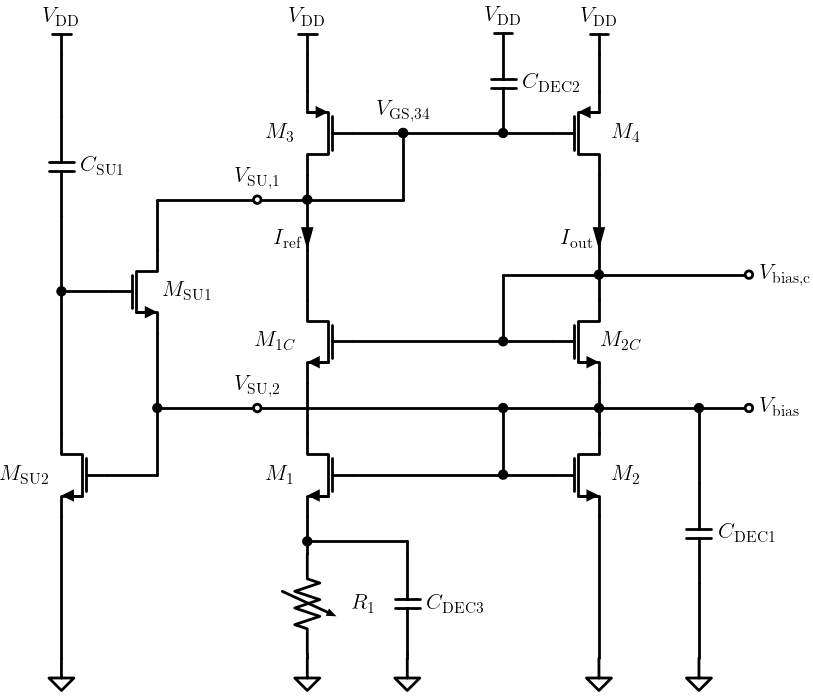

In [70]:
# Draw Bias Circuit v2 without W/L
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=16)
    
    # Vbias
    elm.Dot(open=True).label('$V_\mathrm{bias}$', loc='right', ofst=0.15)
    elm.Line().left().length(1).dot()
    d.push()

    # CDEC1
    elm.Line().down().length(1.5)
    elm.Capacitor().label('$C_\mathrm{DEC1}$', loc='bottom', ofst=0.15).down()
    elm.Line().down().length(1.5)
    gndDot = d.here
    elm.GroundSignal(lead=True)
    d.pop()
    elm.Line().left().length(2)
    biasDot = d.here
    elm.Line().down().length(0.5)

    # M2
    M2 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{2}$', ofst=-1.75).reverse()
    elm.Line().at(M2.source).down().toy(gndDot)
    elm.GroundSignal()
    elm.Line().at(M2.gate).left().length(1).dot()
    M2gate = d.here
    elm.Line().up().toy(biasDot).dot()
    M2gate2 = d.here
    elm.Line().right().tox(biasDot).dot()

    # M2C
    elm.Line().up().length(0.5)
    M2c = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(r'$M_{2C}$', ofst=-1.75).reverse()
    elm.Line().at(M2c.gate).left().length(1).dot()
    M2cgate = d.here
    elm.Line().up().toy(biasDot)
    elm.Line().right().tox(biasDot).dot()
    d.push()
    elm.Line().down().toy(M2c.drain)
    d.pop()
    d.push()
    elm.Line().right().length(3)
    elm.Dot(open=True).label('$V_\mathrm{bias,c}$', loc='right', ofst=0.15)
    d.pop()

    # M4
    elm.Line().up().length(0.50)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'$I_\mathrm{out}$', loc='top', ofst=-0.1).reverse()
    elm.Line().up().length(1.50)
    M4 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{4}$', ofst=-1.75).reverse()
    elm.Line().at(M4.source).up().length(0.75)
    vddDot = d.here
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M4.gate).left().length(1).dot()

    # CDEC2
    d.push()
    elm.Capacitor().label('$C_\mathrm{DEC2}$', loc='bottom', ofst=0.15).up()
    elm.Vdd(lead=False).label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    d.pop()
    elm.Line().left().length(2).dot()
    elm.Dot(open=False).label('$V_\mathrm{GS,34}$', loc='top', ofst=0.15)
    Vgs34 = d.here

    # M3
    elm.Line().left().length(1)
    M3 = elm.AnalogPFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{3}$', ofst=0.25)
    elm.Line().at(M3.source).up().length(0.75)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M3.drain).down().length(0.5).dot()
    d.push()
    elm.Line().left().length(1)
    elm.Dot(open=True).label('$V_\mathrm{SU,1}$', loc='top', ofst=0.15)
    Vsu1Dot = d.here
    d.pop()
    d.push()
    elm.Line().right().tox(Vgs34)
    elm.Line().up().toy(Vgs34)
    d.pop()

    # M1C
    elm.Line().down().length(1)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'$I_\mathrm{ref}$', loc='top', ofst=-0.1)
    elm.Line().down().toy(M2c.drain)
    M1c = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{1C}$', ofst=0.25)
    elm.Line().at(M1c.gate).right().tox(M2cgate)

    # M1
    elm.Line().at(M1c.source).down().toy(M2.drain)
    M1 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{1}$', ofst=0.25)
    elm.Line().at(M1.gate).right().tox(M2gate)
    elm.Line().at(M1.source).down().length(0.5).dot()

    # CDEC3
    d.push()
    elm.Line().right().length(2)
    elm.Line().down().length(0.25)
    elm.Capacitor().label('$C_\mathrm{DEC3}$', loc='bottom', ofst=0.15).down()
    elm.Line().down().toy(gndDot)
    elm.GroundSignal()
    d.pop()

    # R1
    elm.Line().down().length(0.25)
    elm.ResistorVarIEEE().label('$R_\mathrm{1}$', loc='bottom', ofst=0.15).down()
    elm.Line().down().toy(gndDot)
    elm.GroundSignal()

    # VSU2
    elm.Line().at(M2gate2).left().tox(Vsu1Dot)
    elm.Dot(open=True).label('$V_\mathrm{SU,2}$', loc='top', ofst=0.15)
    Vsu2Dot = d.here

    # Start-Up Circuit
    # MSU1
    elm.Line().at(Vsu1Dot).left().length(2)
    elm.Line().down().length(1)
    MSU1 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_\mathrm{SU1}$', ofst=-2).reverse()
    elm.Line().down().toy(Vsu2Dot).dot()
    d.push()
    elm.Line().right().tox(Vsu2Dot)
    d.pop()

    # MSU2
    elm.Line().down().toy(M1.gate)
    elm.Line().left().length(1)
    MSU2 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_\mathrm{SU2}$', ofst=0.25)
    elm.Line().down().toy(gndDot)
    elm.GroundSignal()
    elm.Line().at(MSU2.drain).up().toy(MSU1.gate).dot()
    d.push()
    elm.Line().right().tox(MSU1.gate)
    d.pop()

    # CSU1
    elm.Line().up().length(1.5)
    elm.Capacitor().label('$C_\mathrm{SU1}$', loc='bottom', ofst=0.15).up()
    elm.Line().up().toy(vddDot)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)

    # Save the schematic
    d.save('figures/bias_circuit/bias_circuit_v2_circuit.svg')
    d.save('figures/bias_circuit/bias_circuit_v2_circuit.pdf')

Specifications

In [71]:
# Version 2 is nearly the same as version 1 but now M1 and M2 are split into two current mirrors with half of the length.
# Hence, in total the length is again 40um, but with increased output impedance.
# Simulation showed that a cascoded PMOS current mirror decreases the PSRR and therefore no cascode is used.

# Initial guess of L
l_34 = 4 * 10
l_12c = 2 * 10
l_12 = 2 * 10

# The generated reference current equals
Iref = 10e-9
print('Iref =', round(float(Iref) * 1e9, 2), 'nA')
print('total supply current of bias circuit = 2 * Iref =', round(float(2 * Iref) * 1e9, 1), 'nA')

# The core of the circuit consists of two self-biased current mirrors, resulting into the following currents after start-up.
# i_m1 = i_m3 == i_m2 = i_m4 = Iref

# Voltage drop across R_1 at 10nA
# If V_R is increased, R_1_bias is increased (lower C_1_bias), but gm/ID is decreased, decreasing w_1 / w_2.
V_R = 32.99e-3 # K = 4
print('V_R =', round(float(V_R) * 1e3, 2), 'mV')

# Calculate resistor R_1
R_1_bias = V_R / Iref
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')

Iref = 10.0 nA
total supply current of bias circuit = 2 * Iref = 20.0 nA
V_R = 32.99 mV
R_1_bias = 3.3 MOhm


Look-up

In [72]:
# Sizing of NMOS M2

# According to [Jespers / Murmann] (5.6) or [Carusone] (7.8)
# gm_m2 = 2 / R_1_bias * (1 - np.sqrt(w_2 / w_1))
# Thus, the transconductance of M2 is determined by and geometric ratios only, 
# independent of power-supply voltages, process parameters, temperature, or any other parameters with large variability.
# Not only gm_m2 is stabilized, but all other transconductances are also stabilized since all transistor currents are derived from the same biasing network.

# Transconductance (gm) from gm/ID and ID of M2
# If W1 = K * W2, this formula simplifies to gm_m2 = 2 / R_1_bias * (1 - 1 / np.sqrt(K))
# If K = 4, this formula simplifies to gm_m2 = 1 / R_1_bias
# If K is increased, gm/ID increases and therefore w_1 increases.
# If K is too small, V_R must be decreased resulting into a higher R_1_bias, but at the same time w_2 reduces.
K = 4
gm_m2 = 2 / R_1_bias * (1 - 1 / np.sqrt(K))
print(f"gm_m2 = {round(float(gm_m2) * 1e6, 2)}uS")

# gm/ID of M2
gm_id_m2 = gm_m2 / Iref
print(f"gm_id_m2 = {round(float(gm_id_m2), 2)} S/A")

# Vds,sat of M2
Vds_sat_m2 = 2 / gm_id_m2
print('Vds_sat_m2 =', round(float(Vds_sat_m2), 2), 'V')

# Vgs of M2
Vgs_m2 = lv_nmos.lookupVGS(GM_ID=gm_id_m2, L=l_12, VSB=0)
print('Vgs_m2 =', round(float(Vgs_m2), 2), 'V')

# Vds of M2
# Since M2 is diode connected, Vgs and Vds equal the same.
Vds_m2 = Vgs_m2
if Vds_m2 > Vds_sat_m2: 
  print('Vds_m2 =', round(float(Vds_m2), 2), 'V > Vds_sat_m2 --> M2 operates in saturation (check)')
else:
  print('Vds_m2 =', round(float(Vds_m2), 2), 'V < Vds_sat_m2 --> M2 does NOT operate in saturation!!!')

# Output Conductance (gds) of M2
gm_gds_m2 = lv_nmos.lookup("GM_GDS", L=l_12, VGS=Vgs_m2, VDS=Vds_m2, VSB=0)
gds_m2 = gm_m2 / gm_gds_m2
print(f"gds_m2 = {round(float(gds_m2) * 1e9, 2)}nS (= {round(float(1/gds_m2) * 1e-6, 2)}MOhm)")

# ID/W of M2
id_W_m2 = lv_nmos.lookup("ID_W", L=l_12, VGS=Vgs_m2, VDS=Vds_m2, VSB=0)
w_2 = Iref / id_W_m2
print(f"w_2 = {round(float(w_2), 2)} um ~ {round_to(float(w_2), 0.5)} um (rounded)")

gm_m2 = 0.3uS
gm_id_m2 = 30.31 S/A
Vds_sat_m2 = 0.07 V
Vgs_m2 = 0.1 V
Vds_m2 = 0.1 V > Vds_sat_m2 --> M2 operates in saturation (check)
gds_m2 = 12.23nS (= 81.78MOhm)
w_2 = 5.02 um ~ 5.0 um (rounded)


In [73]:
# Sizing of NMOS M1

# Width of M1
w_1 = K * w_2
print(f"w_1 = {round(float(w_1), 2)} um ~ {round_to(float(w_1), 0.5)} um (rounded)")

# Vgs of M1
Vgs_m1 = Vgs_m2 - Iref * R_1_bias
print('Vgs_m1 =', round(float(Vgs_m1), 2), 'V')

# gm/ID of M1
gm_id_m1 = lv_nmos.lookup("GM_ID", L=l_12, VGS=Vgs_m1, VSB=V_R)
print(f"gm_id_m1 = {round(float(gm_id_m1), 2)} S/A")

# Vds,sat of M1
Vds_sat_m1 = 2 / gm_id_m1
print('Vds_sat_m1 =', round(float(Vds_sat_m1), 2), 'V')

# Transconductance (gm) from gm/ID and ID of M1
gm_m1 = Iref * gm_id_m1
print(f"gm_m1 = {round(float(gm_m1) * 1e6, 2)}uS")

# Output Conductance (gds) of M1
gm_gds_m1 = lv_nmos.lookup("GM_GDS", L=l_12, VGS=Vgs_m1, VSB=V_R)
gds_m1 = gm_m1 / gm_gds_m1
print(f"gds_m1 = {round(float(gds_m1) * 1e9, 2)}nS (= {round(float(1/gds_m1) * 1e-6, 2)}MOhm)")

# Check Vds of M1 after M3 / M4 are sized!

w_1 = 20.09 um ~ 20.0 um (rounded)
Vgs_m1 = 0.07 V
gm_id_m1 = 31.46 S/A
Vds_sat_m1 = 0.06 V
gm_m1 = 0.31uS
gds_m1 = 2.9nS (= 345.08MOhm)


In [74]:
# Sizing of NMOS M1c / M2c

# M2c has a body effect of M2's Vds, since the bulk is connected to GND.
Vsb_m2c = Vds_m2
print('Vsb_m2c =', round(float(Vsb_m2c), 2), 'V')

# M2, M1c and M2c should have the same W/L and therefore need the same Vgs.
# Since M2c has a body effect, Vgs_m2c < Vgs_m2.
Vgs_m2c = Vgs_m2 + 5.85e-3
print('Vgs_m2c =', round(float(Vgs_m2c), 2), 'V')

# Since M2c is diode connected, Vgs and Vds equal the same.
Vds_m2c = Vgs_m2c
print('Vds_m2c =', round(float(Vds_m2c), 2), 'V')

# gm/ID of M2c
gm_id_m2c = lv_nmos.lookup("GM_ID", L=l_12c, VGS=Vgs_m2c, VDS=Vds_m2c, VSB=Vsb_m2c)
print(f"gm_id_m2c = {round(float(gm_id_m2c), 2)} S/A")

# Vds,sat of M2c
Vds_sat_m2c = 2 / gm_id_m2c
print('Vds_sat_m2c =', round(float(Vds_sat_m2c), 2), 'V')

# Transconductance (gm) from gm/ID and ID of M2c
gm_m2c = Iref * gm_id_m2c
print(f"gm_m2c = {round(float(gm_m2c) * 1e6, 2)}uS")

# Output Conductance (gds) of M2c
gm_gds_m2c = lv_nmos.lookup("GM_GDS", L=l_12c, VGS=Vgs_m2c, VDS=Vds_m2c, VSB=Vsb_m2c)
gds_m2c = gm_m2c / gm_gds_m2c
print(f"gds_m2c = {round(float(gds_m2c) * 1e9, 4)}nS (= {round(float(1/gds_m2c) * 1e-6, 2)}MOhm)")

# ID/W of M2c
id_W_m2c = lv_nmos.lookup("ID_W", L=l_12c, VGS=Vgs_m2c, VDS=Vds_m2c, VSB=Vsb_m2c)
w_2c = Iref / id_W_m2c
print(f"w_2c = {round(float(w_2c), 2)} um ~ {round_to(float(w_2c), 0.5)} um (rounded)")

# Width of M1c
w_1c = w_2c
print(f"w_1c = {round(float(w_1c), 2)} um ~ {round_to(float(w_1c), 0.5)} um (rounded)")

Vsb_m2c = 0.1 V
Vgs_m2c = 0.11 V
Vds_m2c = 0.11 V
gm_id_m2c = 30.67 S/A
Vds_sat_m2c = 0.07 V
gm_m2c = 0.31uS
gds_m2c = 10.1768nS (= 98.26MOhm)
w_2c = 5.0 um ~ 5.0 um (rounded)
w_1c = 5.0 um ~ 5.0 um (rounded)


In [75]:
# Calculate cascoded output impedance
print(f"The cascoded output impedance equals 1 / (gds_m2 * gds_m2c / gm_m2c) = {round(float(1 / (gds_m2 * gds_m2c / gm_m2c)) * 1e-9, 2)} GOhm > 1 / gds_m2 = {round(float(1 / gds_m2) * 1e-6, 2)} MOhm.")

The cascoded output impedance equals 1 / (gds_m2 * gds_m2c / gm_m2c) = 2.46 GOhm > 1 / gds_m2 = 81.78 MOhm.


In [76]:
# Sizing of PMOS M3 / M4

# Since M3 and M4 have the same W/L, they have the same gm/ID and Vgs.
# Set Vgs_m34 for a convenient W/L ratio and that M1 / M2 are in saturation.
# Decreasing Vgs, increases gm/ID and increases W.
# Make Vgs_m34 low, for high Vds_m1 and high gds.
# In general, simulation shows that the reference performance is better with wider M3 / M4.
# However, do not make the widths too large, since the performance is only improving slightly. Find a compromise.
# Make w_3 + w_4 + w_dec2 ~ w_1 + w_2 + w_su1 + w_su2 + w_dec1 for a good matching layout.
Vgs_m34 = 0.2854
print('Vgs_m34 =', round(float(Vgs_m34), 2), 'V')

# Vds of M3
# Since M3 is diode connected, Vgs_m34 and Vds_m3 are equal.
# Vds_m4 can be equal Vds_m3, but is not a must, this depends on their load.
# This should be clear by looking at the ID(Vds) curves of a MOSFET.
Vds_m3 = Vgs_m34
print('Vds_m3 =', round(float(Vds_m3), 2), 'V')

# Vds of M4
Vds_m4 = VDD - Vgs_m2
print('Vds_m4 =', round(float(Vds_m4), 2), 'V')

# The next values are only approximately the same for M3 / M4, since Vds_m3 != Vds_m4, 
# but will not be taken into account now and these values are only a weak function of Vds (if in saturation).

# gm/ID of M3 / M4
gm_id_m34 = lv_pmos.lookup("GM_ID", L=l_12, VGS=Vgs_m34, VSB=0)
print(f"gm_id_m34 = {round(float(gm_id_m34), 2)} S/A")

# Vds,sat of M3 / M4
Vds_sat_m34 = 2 / gm_id_m34
if (Vds_sat_m34 < Vds_m3) and (Vds_sat_m34 < Vds_m4): 
  print('Vds_sat_m34 =', round(float(Vds_sat_m34), 2), 'V < Vds_m3 / Vds_m4 --> M3 / M4 operate in saturation (check)')
else:
  print('Vds_sat_m34 =', round(float(Vds_sat_m34), 2), 'V > Vds_m3 / Vds_m4 --> M3 / M4 do NOT operate in saturation!!!')

# Transconductance (gm) from gm/ID and ID of M3 / M4
gm_m34 = Iref * gm_id_m34
print(f"gm_m34 = {round(float(gm_m34) * 1e6, 2)}uS")

# Output Conductance (gds) of M3 / M4
gm_gds_m34 = lv_pmos.lookup("GM_GDS", L=l_34, VGS=Vgs_m34, VSB=0)
gds_m34 = gm_m34 / gm_gds_m34
print(f"gds_m34 = {round(float(gds_m34) * 1e9, 2)}nS (= {round(float(1/gds_m34) * 1e-6, 2)}MOhm)")

# ID/W of M3 / M4
id_W_m34 = lv_pmos.lookup("ID_W", L=l_34, VGS=Vgs_m34, VSB=0)
w_34 = Iref / id_W_m34
print(f"w_34 = {round(float(w_34), 2)} um ~ {round_to(float(w_34), 0.5)} um (rounded)")

Vgs_m34 = 0.29 V
Vds_m3 = 0.29 V
Vds_m4 = 1.4 V
gm_id_m34 = 29.58 S/A
Vds_sat_m34 = 0.07 V < Vds_m3 / Vds_m4 --> M3 / M4 operate in saturation (check)
gm_m34 = 0.3uS
gds_m34 = 0.04nS (= 26077.61MOhm)
w_34 = 20.0 um ~ 20.0 um (rounded)


Start-up Circuit

In [77]:
# The same start-up circuit as in version 1 is used.
# However, the value of Csu changed slightly.
C_su = 35e-15

Power-Down & Decoupling Transistors

In [78]:
# The same power-down transistors as in version 1 are used.

# The decoupling transistors change to the following values.
w_dec1 = 100.0
print(f"w_dec1 = {round(float(w_dec1), 2)} um")

w_dec2 = 25.0
print(f"w_dec2 = {round(float(w_dec2), 2)} um")

l_dec12 = 40.0
print(f"l_dec12 = {round(float(l_dec12), 2)} um")

w_dec1 = 100.0 um
w_dec2 = 25.0 um
l_dec12 = 40.0 um


Store values for other sizing scripts

In [79]:
# Save widths, lengths and voltages for amplifier_core sizing script

Vbiasc = Vds_m2 + Vds_m2c
%store Vbiasc
print('Vbiasc =', round(float(Vbiasc), 3), 'V')

Vbias = Vds_m2
%store Vbias
print('Vbias =', round(float(Vbias), 3), 'V')

Ibias = Iref
%store Ibias
print('Ibias =', round(float(Ibias * 1e9), 2), 'nA \n')

l_mxc = l_12
%store l_mxc
print('l_mxc =', round(float(l_mxc), 1), 'um')

l_mx = l_12
%store l_mx
print('l_mx =', round(float(l_mx), 1), 'um')

w_mxc = w_1c
%store w_mxc
print('w_mxc =', round(float(w_mxc), 1), 'um')

w_mx = w_2
%store w_mx
print('w_mx =', round(float(w_mx), 1), 'um')

Stored 'Vbiasc' (float64)
Vbiasc = 0.207 V
Stored 'Vbias' (ndarray)
Vbias = 0.101 V
Stored 'Ibias' (float)
Ibias = 10.0 nA 

Stored 'l_mxc' (int)
l_mxc = 20.0 um
Stored 'l_mx' (int)
l_mx = 20.0 um
Stored 'w_mxc' (float64)
w_mxc = 5.0 um
Stored 'w_mx' (float64)
w_mx = 5.0 um


Summarize results

In [80]:
# Print out final design values
print('Beta-multiplier circuit with cascoded NMOS current mirror dimensioning:')
print('-----------------------------------------------')
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')
print('M3 / M4: W =', round(w_34, 2), 'um, L =', l_34, 'um')
print('M1c / M2c: W =', round(w_1c, 2), 'um, L =', l_12, 'um')
print('M1: W =', round(w_1, 1), 'um, L =', l_12, 'um')
print('M2: W =', round(w_2, 1), 'um, L =', l_12, 'um \n')
print('C_su =', round(float(C_su) * 1e15, 2), 'fF')
print('MSU1 / MSU2: W =', round(w_su12, 1), 'um, L =', l_su12, 'um \n')
print('MPD3 / MPD4: W =', round(w_pd, 1), 'um, L =', l_pd, 'um')
print('MPD1 / MPD2: W =', round(w_pd, 1), 'um, L =', l_pd, 'um \n')
print('MDEC1: W =', round(w_dec1, 1), 'um, L =', l_dec12, 'um')
print('MDEC2: W =', round(w_dec2, 1), 'um, L =', l_dec12, 'um')
print()
print('Beta-multiplier circuit with cascoded NMOS current mirror performance summary:')
print('-----------------------------------------------')
print('Vgs_m34 =', round(float(Vgs_m34), 3), 'V')
print('Vbias = Vds_m2 =', round(float(Vds_m2), 3), 'V')
print('Vbiasc = Vds_m2 + Vds_m2c =', round(float(Vds_m2 + Vds_m2c), 3), 'V')
print('V_R =', round(float(V_R) * 1e3, 3), 'mV')
print('total supply current of bias circuit = 2 * Iref =', round(float(2 * Iref) * 1e9, 1), 'nA')

Beta-multiplier circuit with cascoded NMOS current mirror dimensioning:
-----------------------------------------------
R_1_bias = 3.3 MOhm
M3 / M4: W = 20.0 um, L = 40 um
M1c / M2c: W = 5.0 um, L = 20 um
M1: W = 20.1 um, L = 20 um
M2: W = 5.0 um, L = 20 um 

C_su = 35.0 fF
MSU1 / MSU2: W = 1.0 um, L = 40 um 

MPD3 / MPD4: W = 1.0 um, L = 0.13 um
MPD1 / MPD2: W = 1.0 um, L = 0.13 um 

MDEC1: W = 100.0 um, L = 40.0 um
MDEC2: W = 25.0 um, L = 40.0 um

Beta-multiplier circuit with cascoded NMOS current mirror performance summary:
-----------------------------------------------
Vgs_m34 = 0.285 V
Vbias = Vds_m2 = 0.101 V
Vbiasc = Vds_m2 + Vds_m2c = 0.207 V
V_R = 32.99 mV
total supply current of bias circuit = 2 * Iref = 20.0 nA


Simulation

In [81]:
# Since all biasing transistors in the amplifier core consist of stacked transistors,
# the bias circuit is also built with stacked transistors, otherwise, the current mirroring would be not precise.

# Due to the stacked transistors and the occurring body effect, the power-down switches and the decoupling capacitors, 
# Iref / Iout changed and therefore R_1_bias must be adapted.
R_1_bias = 3.72e6

V_R = 37.61e-3

# Due the stacked transistors Vgs_m34 slightly decreases and Vbias / Vbiasc increases.
Vgs_m34 = 1.5 - 1.22
Vds_m2 = 0.128
Vds_m2c = 0.275 - Vds_m2

# Print out final design values
print('Beta-multiplier circuit with cascoded NMOS current mirror dimensioning:')
print('-----------------------------------------------')
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')
print('M3 / M4: W =', round(w_34, 2), 'um, L =', l_34, 'um')
print('M1c / M2c: W =', round(w_1c, 2), 'um, L =', l_12, 'um')
print('M1: W =', round(w_1, 1), 'um, L =', l_12, 'um')
print('M2: W =', round(w_2, 1), 'um, L =', l_12, 'um \n')
print('C_su =', round(float(C_su) * 1e15, 2), 'fF')
print('MSU1 / MSU2: W =', round(w_su12, 1), 'um, L =', l_su12, 'um \n')
print('MPD3 / MPD4: W =', round(w_pd, 1), 'um, L =', l_pd, 'um')
print('MPD1 / MPD2: W =', round(w_pd, 1), 'um, L =', l_pd, 'um \n')
print('MDEC1: W =', round(w_dec1, 1), 'um, L =', l_dec12, 'um')
print('MDEC2: W =', round(w_dec2, 1), 'um, L =', l_dec12, 'um')
print()
print('Beta-multiplier circuit with cascoded NMOS current mirror performance summary:')
print('-----------------------------------------------')
print('Vgs_m34 =', round(float(Vgs_m34), 3), 'V')
print('Vbias = Vds_m2 =', round(float(Vds_m2), 3), 'V')
print('Vbiasc = Vds_m2 + Vds_m2c =', round(float(Vds_m2 + Vds_m2c), 3), 'V')
print('V_R =', round(float(V_R) * 1e3, 3), 'mV')
print('total supply current of bias circuit (power up, enable up) =', round(20.26, 1), 'nA')
print('total supply current of bias circuit (power up, enable down) =', round(346, 1), 'pA')
print('VDD_min =', round(float(0.55), 2), 'V (99% of nominal Iout = 9.9nA)')
print('Iout(VDD=1.4V) = 10.044nA, Iout(VDD=1.3V) = 10.027nA -->', round(170.8, 2), 'pA/V')
print('Ix(Vout=0V) = 9.9941nA, Iout(VDD=1V) = 9.9596nA -->', round(34.51, 2), 'pA/V')
print('Vbias(Troom=27°C) = 0.128V, Vbias(Tmin=0°C) = 0.152V, Vbias(Tmax=70°C) = 0.088V -->', round(-7132, 2), 'ppm/°C \n') # ppm_deg = (dVbias / Vbias_Troom) * (1e6 / dT)
print('Ix(Troom=27°C) = 9.97nA, Ix(Tmin=0°C) = 9.24nA, Ix(Tmax=70°C) = 10.39nA -->', round(1645, 2), 'ppm/°C \n') # ppm_deg = (dIx / Ix_Troom) * (1e6 / dT)
print('PSRR(f=1Hz) =', round(53.91, 2), 'dB \n')
print('Start-up settling time =', round(321, 2), 'us (99% of nominal Iout = 9.9nA)')

Beta-multiplier circuit with cascoded NMOS current mirror dimensioning:
-----------------------------------------------
R_1_bias = 3.72 MOhm
M3 / M4: W = 20.0 um, L = 40 um
M1c / M2c: W = 5.0 um, L = 20 um
M1: W = 20.1 um, L = 20 um
M2: W = 5.0 um, L = 20 um 

C_su = 35.0 fF
MSU1 / MSU2: W = 1.0 um, L = 40 um 

MPD3 / MPD4: W = 1.0 um, L = 0.13 um
MPD1 / MPD2: W = 1.0 um, L = 0.13 um 

MDEC1: W = 100.0 um, L = 40.0 um
MDEC2: W = 25.0 um, L = 40.0 um

Beta-multiplier circuit with cascoded NMOS current mirror performance summary:
-----------------------------------------------
Vgs_m34 = 0.28 V
Vbias = Vds_m2 = 0.128 V
Vbiasc = Vds_m2 + Vds_m2c = 0.275 V
V_R = 37.61 mV
total supply current of bias circuit (power up, enable up) = 20.3 nA
total supply current of bias circuit (power up, enable down) = 346 pA
VDD_min = 0.55 V (99% of nominal Iout = 9.9nA)
Iout(VDD=1.4V) = 10.044nA, Iout(VDD=1.3V) = 10.027nA --> 170.8 pA/V
Ix(Vout=0V) = 9.9941nA, Iout(VDD=1V) = 9.9596nA --> 34.51 pA/V
Vbias(Tr

Conclusion

In [82]:
# Version 2 already increased the output impedance quite well and is nearly constant against VDD down to 0.54V.
# However, the PSRR decreased to 53.89dB. Therefore, the usage of an auxiliary amplifier, utilizing negative feedback is recommended.

# This auxiliary amplifier tries to regulate the voltage difference of Vds_m1 and Vds_m2 to zero (Vds_m1 - Vds_m2 = 0V) 
# by setting Vgs_m34 and therefore forces all currents to be equal.
# Hence, the output impedance and the PSRR should be increased.
# A few millivolts difference at the output voltage is acceptable and 
# therefore the dc open-loop gain of this auxiliary amplifiers is not that important.
# In [Baker] a gain of approximately 20-30dB is recommended.

# This circuit is sized in version 3 and can be found in [Baker] in Fig. 23.7 and
# https://positivefb.com/beta-multiplier-reference/.

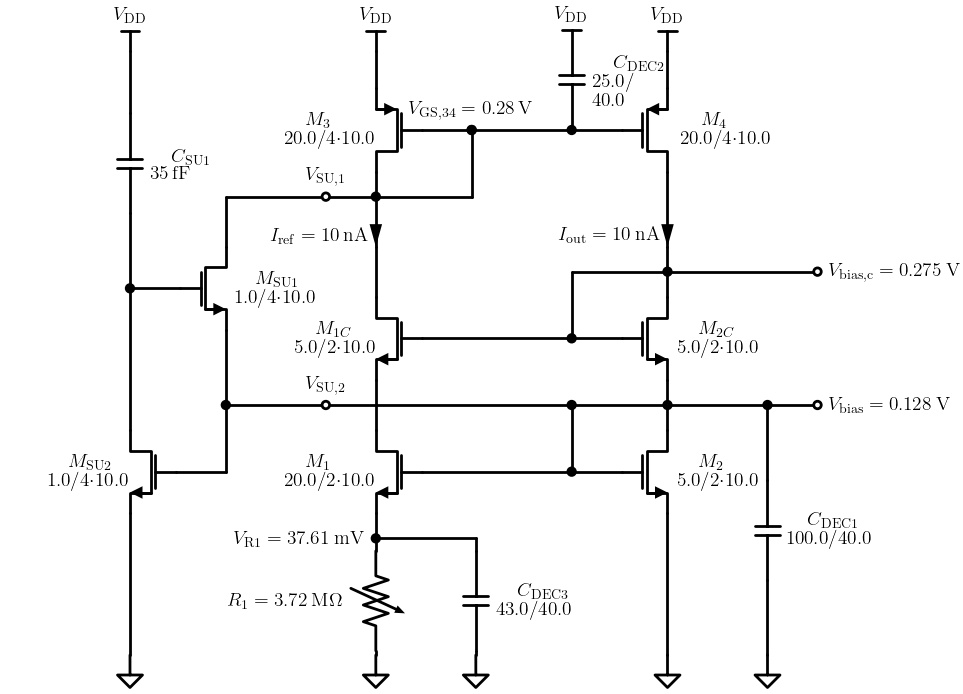

In [83]:
# Draw Bias Circuit v2 with W/L

w_34 = round(w_34, 2)
w_1c = round(w_1c, 2)
w_1 = round(w_1, 0)
w_2 = round(w_2, 1)
w_su12 = round(w_su12, 1)
w_dec1 = round(w_dec1, 1)
w_dec2 = round(w_dec2, 1)

import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=14)
    
    # Vbias
    elm.Dot(open=True).label(r'$V_\mathrm{bias} = 0.128\,\textrm{V}$', loc='right', ofst=0.15)
    elm.Line().left().length(1).dot()
    d.push()

    # CDEC1
    elm.Line().down().length(1.5)
    elm.Capacitor().label(r'$C_\mathrm{DEC1} \\$'+str(w_dec1/1.0)+'/'+str(l_dec12/1.0), loc='bottom', ofst=0.15).down()
    elm.Line().down().length(1.5)
    gndDot = d.here
    elm.GroundSignal(lead=True)
    d.pop()
    elm.Line().left().length(2)
    biasDot = d.here
    elm.Line().down().length(0.5)

    # M2
    M2 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{2} \\$'+str(w_2/1.0)+'/'+r'$2 \cdot$'+str(l_12/2.0), ofst=-2.75).reverse()
    elm.Line().at(M2.source).down().toy(gndDot)
    elm.GroundSignal()
    elm.Line().at(M2.gate).left().length(1).dot()
    M2gate = d.here
    elm.Line().up().toy(biasDot).dot()
    M2gate2 = d.here
    elm.Line().right().tox(biasDot).dot()

    # M2C
    elm.Line().up().length(0.5)
    M2c = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(r'$M_{2C} \\$'+str(w_1c/1.0)+'/'+r'$2 \cdot$'+str(l_12/2.0), ofst=-2.75).reverse()
    elm.Line().at(M2c.gate).left().length(1).dot()
    M2cgate = d.here
    elm.Line().up().toy(biasDot)
    elm.Line().right().tox(biasDot).dot()
    d.push()
    elm.Line().down().toy(M2c.drain)
    d.pop()
    d.push()
    elm.Line().right().length(3)
    elm.Dot(open=True).label(r'$V_\mathrm{bias,c} = 0.275\,\textrm{V}$', loc='right', ofst=0.15)
    d.pop()

    # M4
    elm.Line().up().length(0.50)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'$I_\mathrm{out} = 10\,\textrm{nA}$', loc='top', ofst=-0.1).reverse()
    elm.Line().up().length(1.50)
    M4 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{4} \\$'+str(w_34/1.0)+'/'+r'$4 \cdot$'+str(l_34/4.0), ofst=-3).reverse()
    elm.Line().at(M4.source).up().length(0.75)
    vddDot = d.here
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M4.gate).left().length(1).dot()

    # CDEC2
    d.push()
    elm.Capacitor().label(r'$C_\mathrm{DEC2} \\$'+str(w_dec2/1.0)+'/'+r'$\\$'+str(l_dec12/1.0), loc='bottom', ofst=0.15).up()
    elm.Vdd(lead=False).label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    d.pop()
    elm.Line().left().length(2).dot()
    elm.Dot(open=False).label(r'$V_\mathrm{GS,34} = 0.28\,\textrm{V}$', loc='top', ofst=0.15)
    Vgs34 = d.here

    # M3
    elm.Line().left().length(1)
    M3 = elm.AnalogPFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{3} \\$'+str(w_34/1.0)+'/'+r'$4 \cdot$'+str(l_34/4.0), ofst=0.0)
    elm.Line().at(M3.source).up().length(0.75)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M3.drain).down().length(0.5).dot()
    d.push()
    elm.Line().left().length(1)
    elm.Dot(open=True).label('$V_\mathrm{SU,1}$', loc='top', ofst=0.15)
    Vsu1Dot = d.here
    d.pop()
    d.push()
    elm.Line().right().tox(Vgs34)
    elm.Line().up().toy(Vgs34)
    d.pop()

    # M1C
    elm.Line().down().length(1)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'$I_\mathrm{ref} = 10\,\textrm{nA}$', loc='top', ofst=-0.1)
    elm.Line().down().toy(M2c.drain)
    M1c = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{1C} \\$'+str(w_1c/1.0)+'/'+r'$2 \cdot$'+str(l_12/2.0), ofst=0.0)
    elm.Line().at(M1c.gate).right().tox(M2cgate)

    # M1
    elm.Line().at(M1c.source).down().toy(M2.drain)
    M1 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{1} \\$'+str(w_1/1.0)+'/'+r'$2 \cdot$'+str(l_12/2.0), ofst=0.0)
    elm.Line().at(M1.gate).right().tox(M2gate)
    elm.Line().at(M1.source).down().length(0.5)
    elm.Dot(open=False).label(r'$V_\mathrm{R1} = 37.61\,\textrm{mV}$', loc='left', ofst=0.15)

    # CDEC3
    d.push()
    elm.Line().right().length(2)
    elm.Line().down().length(0.25)
    elm.Capacitor().label(r'$C_\mathrm{DEC3} \\$ 43.0/40.0', loc='bottom', ofst=0.15).down()
    elm.Line().down().toy(gndDot)
    elm.GroundSignal()
    d.pop()

    # R1
    elm.Line().down().length(0.25)
    elm.ResistorVarIEEE().label(r'$R_\mathrm{1} = 3.72\,\textrm{M}\Omega$', loc='top', ofst=0.0).down()
    elm.Line().down().toy(gndDot)
    elm.GroundSignal()

    # VSU2
    elm.Line().at(M2gate2).left().tox(Vsu1Dot)
    elm.Dot(open=True).label('$V_\mathrm{SU,2}$', loc='top', ofst=0.15)
    Vsu2Dot = d.here

    # Start-Up Circuit
    # MSU1
    elm.Line().at(Vsu1Dot).left().length(2)
    elm.Line().down().length(1)
    MSU1 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_\mathrm{SU1} \\$'+str(w_su12/1.0)+'/'+r'$4 \cdot$'+str(l_su12/4.0), ofst=-2.75).reverse()
    elm.Line().down().toy(Vsu2Dot).dot()
    d.push()
    elm.Line().right().tox(Vsu2Dot)
    d.pop()

    # MSU2
    elm.Line().down().toy(M1.gate)
    elm.Line().left().length(1)
    MSU2 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_\mathrm{SU2} \\$'+str(w_su12/1.0)+'/'+r'$4 \cdot$'+str(l_su12/4.0), ofst=0.0)
    elm.Line().down().toy(gndDot)
    elm.GroundSignal()
    elm.Line().at(MSU2.drain).up().toy(MSU1.gate).dot()
    d.push()
    elm.Line().right().tox(MSU1.gate)
    d.pop()

    # CSU1
    elm.Line().up().length(1.5)
    elm.Capacitor().label(r'$C_\mathrm{SU1} \\$ 35\,fF', loc='bottom', ofst=0.15).up()
    elm.Line().up().toy(vddDot)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)

    # Save the schematic
    d.save('figures/bias_circuit/bias_circuit_v2_WL_circuit.svg')
    d.save('figures/bias_circuit/bias_circuit_v2_WL_circuit.pdf')

## Version 3 - Beta-multiplier reference with auxiliary amplifier

Drawing

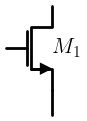

In [84]:
# Draw Bias Circuit v3 without W/L
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=16)
    
    M1 = elm.AnalogNFet(offset_gate=False).drop('source').theta(0).label('$M_1$', ofst=-1.5).reverse()
    elm.Line().down().length(0.5)
    
    # ToDo Draw Circuit

    # Save the schematic
    d.save('figures/bias_circuit/bias_circuit_v3_circuit.svg')
    d.save('figures/bias_circuit/bias_circuit_v3_circuit.pdf')

Specifications

In [85]:
# Version 3 is version 2 with an additional auxiliary amplifier.

# Initial guess of L
l_34 = 4 * 10
l_12c = 2 * 10
l_12 = 2 * 10

# Auxiliary Amplifier
l_a34 = 4 * 10
l_a12 = 4 * 10

# The generated reference current equals
Iref = 10e-9
print('Iref =', round(float(Iref) * 1e9, 2), 'nA')

# The current of the auxiliary amplifier (per branch) equals
Iamp = Iref
print('Iamp =', round(float(Iamp) * 1e9, 2), 'nA')

print('total supply current of bias circuit = 2 * Iref + 2 * Iamp =', round(float(2 * Iref + 2 * Iamp) * 1e9, 1), 'nA')

# The core of the circuit consists of two self-biased current mirrors, resulting into the following currents after start-up.
# i_m1 = i_m3 == i_m2 = i_m4 = Iref

# Voltage drop across R_1 at 10nA
# If V_R is increased, R_1_bias is increased (lower C_1_bias), but gm/ID is decreased, decreasing w_1 / w_2.
V_R = 32.99e-3 # K = 4
print('V_R =', round(float(V_R) * 1e3, 2), 'mV')

# Calculate resistor R_1
R_1_bias = V_R / Iref
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')

Iref = 10.0 nA
Iamp = 10.0 nA
total supply current of bias circuit = 2 * Iref + 2 * Iamp = 40.0 nA
V_R = 32.99 mV
R_1_bias = 3.3 MOhm


Look-up

In [86]:
# Sizing of NMOS M2

# According to [Jespers / Murmann] (5.6) or [Carusone] (7.8)
# gm_m2 = 2 / R_1_bias * (1 - np.sqrt(w_2 / w_1))
# Thus, the transconductance of M2 is determined by and geometric ratios only, 
# independent of power-supply voltages, process parameters, temperature, or any other parameters with large variability.
# Not only gm_m2 is stabilized, but all other transconductances are also stabilized since all transistor currents are derived from the same biasing network.

# Transconductance (gm) from gm/ID and ID of M2
# If W1 = K * W2, this formula simplifies to gm_m2 = 2 / R_1_bias * (1 - 1 / np.sqrt(K))
# If K = 4, this formula simplifies to gm_m2 = 1 / R_1_bias
# If K is increased, gm/ID increases and therefore w_1 increases.
# If K is too small, V_R must be decreased resulting into a higher R_1_bias, but at the same time w_2 reduces.
K = 4
gm_m2 = 2 / R_1_bias * (1 - 1 / np.sqrt(K))
print(f"gm_m2 = {round(float(gm_m2) * 1e6, 2)}uS")

# gm/ID of M2
gm_id_m2 = gm_m2 / Iref
print(f"gm_id_m2 = {round(float(gm_id_m2), 2)} S/A")

# Vds,sat of M2
Vds_sat_m2 = 2 / gm_id_m2
print('Vds_sat_m2 =', round(float(Vds_sat_m2), 2), 'V')

# Vgs of M2
Vgs_m2 = lv_nmos.lookupVGS(GM_ID=gm_id_m2, L=l_12, VSB=0)
print('Vgs_m2 =', round(float(Vgs_m2), 2), 'V')

# Vds of M2
# Since M2 is diode connected, Vgs and Vds equal the same.
Vds_m2 = Vgs_m2
if Vds_m2 > Vds_sat_m2: 
  print('Vds_m2 =', round(float(Vds_m2), 2), 'V > Vds_sat_m2 --> M2 operates in saturation (check)')
else:
  print('Vds_m2 =', round(float(Vds_m2), 2), 'V < Vds_sat_m2 --> M2 does NOT operate in saturation!!!')

# Output Conductance (gds) of M2
gm_gds_m2 = lv_nmos.lookup("GM_GDS", L=l_12, VGS=Vgs_m2, VDS=Vds_m2, VSB=0)
gds_m2 = gm_m2 / gm_gds_m2
print(f"gds_m2 = {round(float(gds_m2) * 1e9, 2)}nS (= {round(float(1/gds_m2) * 1e-6, 2)}MOhm)")

# ID/W of M2
id_W_m2 = lv_nmos.lookup("ID_W", L=l_12, VGS=Vgs_m2, VDS=Vds_m2, VSB=0)
w_2 = Iref / id_W_m2
print(f"w_2 = {round(float(w_2), 2)} um ~ {round_to(float(w_2), 0.5)} um (rounded)")

gm_m2 = 0.3uS
gm_id_m2 = 30.31 S/A
Vds_sat_m2 = 0.07 V
Vgs_m2 = 0.1 V
Vds_m2 = 0.1 V > Vds_sat_m2 --> M2 operates in saturation (check)
gds_m2 = 12.23nS (= 81.78MOhm)
w_2 = 5.02 um ~ 5.0 um (rounded)


In [87]:
# Sizing of NMOS M1

# Width of M1
w_1 = K * w_2
print(f"w_1 = {round(float(w_1), 2)} um ~ {round_to(float(w_1), 0.5)} um (rounded)")

# Vgs of M1
Vgs_m1 = Vgs_m2 - Iref * R_1_bias
print('Vgs_m1 =', round(float(Vgs_m1), 2), 'V')

# gm/ID of M1
gm_id_m1 = lv_nmos.lookup("GM_ID", L=l_12, VGS=Vgs_m1, VSB=V_R)
print(f"gm_id_m1 = {round(float(gm_id_m1), 2)} S/A")

# Vds,sat of M1
Vds_sat_m1 = 2 / gm_id_m1
print('Vds_sat_m1 =', round(float(Vds_sat_m1), 2), 'V')

# Transconductance (gm) from gm/ID and ID of M1
gm_m1 = Iref * gm_id_m1
print(f"gm_m1 = {round(float(gm_m1) * 1e6, 2)}uS")

# Output Conductance (gds) of M1
gm_gds_m1 = lv_nmos.lookup("GM_GDS", L=l_12, VGS=Vgs_m1, VSB=V_R)
gds_m1 = gm_m1 / gm_gds_m1
print(f"gds_m1 = {round(float(gds_m1) * 1e9, 2)}nS (= {round(float(1/gds_m1) * 1e-6, 2)}MOhm)")

# Check Vds of M1 after M3 / M4 are sized!

w_1 = 20.09 um ~ 20.0 um (rounded)
Vgs_m1 = 0.07 V
gm_id_m1 = 31.46 S/A
Vds_sat_m1 = 0.06 V
gm_m1 = 0.31uS
gds_m1 = 2.9nS (= 345.08MOhm)


In [88]:
# Sizing of NMOS M1c / M2c

# M2c has a body effect of M2's Vds, since the bulk is connected to GND.
Vsb_m2c = Vds_m2
print('Vsb_m2c =', round(float(Vsb_m2c), 2), 'V')

# M2, M1c and M2c should have the same W/L and therefore need the same Vgs.
# Since M2c has a body effect, Vgs_m2c < Vgs_m2.
Vgs_m2c = Vgs_m2 + 5.85e-3
print('Vgs_m2c =', round(float(Vgs_m2c), 2), 'V')

# Since M2c is diode connected, Vgs and Vds equal the same.
Vds_m2c = Vgs_m2c
print('Vds_m2c =', round(float(Vds_m2c), 2), 'V')

# gm/ID of M2c
gm_id_m2c = lv_nmos.lookup("GM_ID", L=l_12c, VGS=Vgs_m2c, VDS=Vds_m2c, VSB=Vsb_m2c)
print(f"gm_id_m2c = {round(float(gm_id_m2c), 2)} S/A")

# Vds,sat of M2c
Vds_sat_m2c = 2 / gm_id_m2c
print('Vds_sat_m2c =', round(float(Vds_sat_m2c), 2), 'V')

# Transconductance (gm) from gm/ID and ID of M2c
gm_m2c = Iref * gm_id_m2c
print(f"gm_m2c = {round(float(gm_m2c) * 1e6, 2)}uS")

# Output Conductance (gds) of M2c
gm_gds_m2c = lv_nmos.lookup("GM_GDS", L=l_12c, VGS=Vgs_m2c, VDS=Vds_m2c, VSB=Vsb_m2c)
gds_m2c = gm_m2c / gm_gds_m2c
print(f"gds_m2c = {round(float(gds_m2c) * 1e9, 4)}nS (= {round(float(1/gds_m2c) * 1e-6, 2)}MOhm)")

# ID/W of M2c
id_W_m2c = lv_nmos.lookup("ID_W", L=l_12c, VGS=Vgs_m2c, VDS=Vds_m2c, VSB=Vsb_m2c)
w_2c = Iref / id_W_m2c
print(f"w_2c = {round(float(w_2c), 2)} um ~ {round_to(float(w_2c), 0.5)} um (rounded)")

# Width of M1c
w_1c = w_2c
print(f"w_1c = {round(float(w_1c), 2)} um ~ {round_to(float(w_1c), 0.5)} um (rounded)")

Vsb_m2c = 0.1 V
Vgs_m2c = 0.11 V
Vds_m2c = 0.11 V
gm_id_m2c = 30.67 S/A
Vds_sat_m2c = 0.07 V
gm_m2c = 0.31uS
gds_m2c = 10.1768nS (= 98.26MOhm)
w_2c = 5.0 um ~ 5.0 um (rounded)
w_1c = 5.0 um ~ 5.0 um (rounded)


In [89]:
# Calculate cascoded output impedance
print(f"The cascoded output impedance equals 1 / (gds_m2 * gds_m2c / gm_m2c) = {round(float(1 / (gds_m2 * gds_m2c / gm_m2c)) * 1e-9, 2)} GOhm > 1 / gds_m2 = {round(float(1 / gds_m2) * 1e-6, 2)} MOhm.")

The cascoded output impedance equals 1 / (gds_m2 * gds_m2c / gm_m2c) = 2.46 GOhm > 1 / gds_m2 = 81.78 MOhm.


In [90]:
# Sizing of PMOS M3 / M4

# Since M3 and M4 have the same W/L, they have the same gm/ID and Vgs.
# Set Vgs_m34 for a convenient W/L ratio and that M1 / M2 are in saturation.
# Decreasing Vgs, increases gm/ID and increases W.
# Make Vgs_m34 low, for high Vds_m1 and high gds.
# In general, simulation shows that the reference performance is better with wider M3 / M4.
# However, do not make the widths too large, since the performance is only improving slightly. Find a compromise.
# Make w_3 + w_4 + w_dec2 ~ w_1 + w_2 + w_su1 + w_su2 + w_dec1 for a good matching layout.
# Vgs_m34 is set by the output of the single-ended auxiliary amplifier.
Vgs_m34 = 0.2854
print('Vgs_m34 =', round(float(Vgs_m34), 2), 'V')

# Vds of M3
# Since M3 is diode connected, Vgs_m34 and Vds_m3 are equal.
# Vds_m4 can be equal Vds_m3, but is not a must, this depends on their load.
# This should be clear by looking at the ID(Vds) curves of a MOSFET.
Vds_m3 = Vgs_m34
print('Vds_m3 =', round(float(Vds_m3), 2), 'V')

# Vds of M4
Vds_m4 = VDD - Vgs_m2
print('Vds_m4 =', round(float(Vds_m4), 2), 'V')

# The next values are only approximately the same for M3 / M4, since Vds_m3 != Vds_m4, 
# but will not be taken into account now and these values are only a weak function of Vds (if in saturation).

# gm/ID of M3 / M4
gm_id_m34 = lv_pmos.lookup("GM_ID", L=l_12, VGS=Vgs_m34, VSB=0)
print(f"gm_id_m34 = {round(float(gm_id_m34), 2)} S/A")

# Vds,sat of M3 / M4
Vds_sat_m34 = 2 / gm_id_m34
if (Vds_sat_m34 < Vds_m3) and (Vds_sat_m34 < Vds_m4): 
  print('Vds_sat_m34 =', round(float(Vds_sat_m34), 2), 'V < Vds_m3 / Vds_m4 --> M3 / M4 operate in saturation (check)')
else:
  print('Vds_sat_m34 =', round(float(Vds_sat_m34), 2), 'V > Vds_m3 / Vds_m4 --> M3 / M4 do NOT operate in saturation!!!')

# Transconductance (gm) from gm/ID and ID of M3 / M4
gm_m34 = Iref * gm_id_m34
print(f"gm_m34 = {round(float(gm_m34) * 1e6, 2)}uS")

# Output Conductance (gds) of M3 / M4
gm_gds_m34 = lv_pmos.lookup("GM_GDS", L=l_34, VGS=Vgs_m34, VSB=0)
gds_m34 = gm_m34 / gm_gds_m34
print(f"gds_m34 = {round(float(gds_m34) * 1e9, 2)}nS (= {round(float(1/gds_m34) * 1e-6, 2)}MOhm)")

# ID/W of M3 / M4
id_W_m34 = lv_pmos.lookup("ID_W", L=l_34, VGS=Vgs_m34, VSB=0)
w_34 = Iref / id_W_m34
print(f"w_34 = {round(float(w_34), 2)} um ~ {round_to(float(w_34), 0.5)} um (rounded)")

Vgs_m34 = 0.29 V
Vds_m3 = 0.29 V
Vds_m4 = 1.4 V
gm_id_m34 = 29.58 S/A
Vds_sat_m34 = 0.07 V < Vds_m3 / Vds_m4 --> M3 / M4 operate in saturation (check)
gm_m34 = 0.3uS
gds_m34 = 0.04nS (= 26077.61MOhm)
w_34 = 20.0 um ~ 20.0 um (rounded)


Auxiliary Amplifier

In [91]:
# Sizing of MA3 / MA4

# Vgs of of MA3 / MA4
# Set Vgs_ma34 for a convenient W/L ratio and that MA1 / MA2 are in saturation.
# According to [Baker], MA3 = M3 and MA4 = M4, which results into Vgs_ma34 = Vgs_m34.
Vgs_ma34 = Vgs_m34
print('Vgs_ma34 =', round(float(Vgs_ma34), 2), 'V')

# Vds of of MA3 / MA4
# Since MA3 is diode connected, Vgs and Vds equal the same.
# Vds_ma3 is in general not equal Vds_ma4, but since Vgs_ma34 = Vgs_m34 = Vds_ma3 = Vds_ma4, it is.
Vds_ma34 = Vgs_ma34
print('Vds_ma34 =', round(float(Vds_ma34), 2), 'V')

# gm/ID of MA3 / MA4
gm_id_ma34 = lv_pmos.lookup("GM_GDS", L=l_a34, VGS=Vgs_ma34, VDS=Vds_ma34, VSB=0)
print(f"gm_id_ma34 = {round(float(gm_id_ma34), 2)} S/A")

# Vds,sat of MA3 / MA4
Vds_sat_ma34 = 2 / gm_id_ma34
print('Vds_sat_ma34 =', round(float(Vds_sat_ma34), 2), 'V')

# Transconductance (gm) from gm/ID and ID of MA3 / MA4
gm_ma34 = Iamp * gm_id_ma34
print(f"gm_ma34 = {round(float(gm_ma34) * 1e6, 2)}uS")

# Output Conductance (gds) of MA3 / MA4
gm_gds_ma34 = lv_pmos.lookup("GM_GDS", L=l_a34, VGS=Vgs_ma34, VDS=Vds_ma34, VSB=0)
gds_ma34 = gm_ma34 / gm_gds_ma34
print(f"gds_ma34 = {round(float(gds_ma34) * 1e9, 4)}nS (= {round(float(1/gds_ma34) * 1e-6, 2)}MOhm)")

# ID/W of MA3 / MA4
id_W_ma34 = lv_pmos.lookup("ID_W", L=l_a34, VGS=Vgs_ma34, VDS=Vds_ma34, VSB=0)
w_a34 = Iamp / id_W_ma34
print(f"w_a34 = {round(float(w_a34), 2)} um ~ {round_to(float(w_a34), 0.5)} um (rounded)")

Vgs_ma34 = 0.29 V
Vds_ma34 = 0.29 V
gm_id_ma34 = 3034.56 S/A
Vds_sat_ma34 = 0.0 V
gm_ma34 = 30.35uS
gds_ma34 = 10.0nS (= 100.0MOhm)
w_a34 = 20.04 um ~ 20.0 um (rounded)


In [92]:
# Sizing of MA1 /MA2

# Vgs of of MA1 / MA2
Vgs_ma12 = Vgs_m2
print('Vgs_ma12 =', round(float(Vgs_ma12), 2), 'V')

# Vds of of MA1 / MA2
Vds_ma12 = VDD - Vgs_ma34
print('Vds_ma12 =', round(float(Vds_ma12), 2), 'V')

# gm/ID of MA1 / MA2
gm_id_ma12 = lv_nmos.lookup("GM_GDS", L=l_a12, VGS=Vgs_ma12, VDS=Vds_ma12, VSB=0)
print(f"gm_id_ma12 = {round(float(gm_id_ma12), 2)} S/A")

# Vds,sat of M2
Vds_sat_ma12 = 2 / gm_id_ma12
print('Vds_sat_ma12 =', round(float(Vds_sat_ma12), 2), 'V')

# Transconductance (gm) from gm/ID and ID of MA1 / MA2
gm_ma12 = Iamp * gm_id_ma12
print(f"gm_ma12 = {round(float(gm_ma12) * 1e6, 2)}uS")

# Output Conductance (gds) of MA1 / MA2
gm_gds_ma12 = lv_nmos.lookup("GM_GDS", L=l_a12, VGS=Vgs_ma12, VDS=Vds_ma12, VSB=0)
gds_ma12 = gm_ma12 / gm_gds_ma12
print(f"gds_ma12 = {round(float(gds_ma12) * 1e9, 4)}nS (= {round(float(1/gds_ma12) * 1e-6, 2)}MOhm)")

# ID/W of MA1 / MA2
id_W_ma12 = lv_nmos.lookup("ID_W", L=l_a12, VGS=Vgs_ma12, VDS=Vds_ma12, VSB=0)
w_a12 = Iamp / id_W_ma12
print(f"w_a12 = {round(float(w_a12), 2)} um ~ {round_to(float(w_a12), 0.5)} um (rounded)")

Vgs_ma12 = 0.1 V
Vds_ma12 = 1.21 V
gm_id_ma12 = 182.55 S/A
Vds_sat_ma12 = 0.01 V
gm_ma12 = 1.83uS
gds_ma12 = 10.0nS (= 100.0MOhm)
w_a12 = 5.33 um ~ 5.5 um (rounded)


In [93]:
# DC open-loop gain of auxiliary amplifier
A_ol_0 = gm_ma12 / (gds_ma12 + gds_ma34)
A_ol_0_dB = 20 * np.log10(A_ol_0)
print('A_ol_0 =', round(float(A_ol_0), 2), '/', round(float(A_ol_0_dB), 2), 'dB > 20dB --> check [Baker]')

A_ol_0 = 91.27 / 39.21 dB > 20dB --> check [Baker]


Start-up Circuit

In [94]:
# The same start-up circuit from version 1 is used.
# However, the value of Csu changed slightly.
C_su = 30e-15

Power-Down & Decoupling Transistors

In [95]:
# The same power-down transistors as in version 1 are used.

# The decoupling transistors change to the following values.
w_dec1 = 100.0
print(f"w_dec1 = {round(float(w_dec1), 2)} um")

w_dec2 = 25.0
print(f"w_dec2 = {round(float(w_dec2), 2)} um")

l_dec12 = 40.0
print(f"l_dec12 = {round(float(l_dec12), 2)} um")

w_dec1 = 100.0 um
w_dec2 = 25.0 um
l_dec12 = 40.0 um


Summarize results

In [96]:
# Print out final design values
print('Beta-multiplier circuit with auxiliary amplifier dimensioning:')
print('-----------------------------------------------')
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')
print('M3 / M4: W =', round(w_34, 2), 'um, L =', l_34, 'um')
print('M1c / M2c: W =', round(w_1c, 2), 'um, L =', l_12, 'um')
print('M1: W =', round(w_1, 1), 'um, L =', l_12, 'um')
print('M2: W =', round(w_2, 1), 'um, L =', l_12, 'um \n')
print('MA1 / MA2: W =', round(w_a12, 1), 'um, L =', l_a12, 'um')
print('MA3 / MA4: W =', round(w_a34, 1), 'um, L =', l_a34, 'um \n')
print('C_su =', round(float(C_su) * 1e15, 2), 'fF')
print('MSU1 / MSU2: W =', round(w_su12, 1), 'um, L =', l_su12, 'um \n')
print('MPD3 / MPD4: W =', round(w_pd, 1), 'um, L =', l_pd, 'um')
print('MPD1 / MPD2: W =', round(w_pd, 1), 'um, L =', l_pd, 'um \n')
print('MDEC1: W =', round(w_dec1, 1), 'um, L =', l_dec12, 'um')
print('MDEC2: W =', round(w_dec2, 1), 'um, L =', l_dec12, 'um')
print()
print('Beta-multiplier circuit with auxiliary amplifier performance summary:')
print('-----------------------------------------------')
print('Vgs_m34 =', round(float(Vgs_m34), 2), 'V')
print('Vbias = Vds_m2 =', round(float(Vds_m2), 2), 'V')
print('V_R =', round(float(V_R) * 1e3, 2), 'mV')
print('total supply current of bias circuit = 2 * Iref + 2 * Iamp =', round(float(2 * Iref + 2 * Iamp) * 1e9, 1), 'nA')
print('A_ol_0 =', round(float(A_ol_0), 2), '/', round(float(A_ol_0_dB), 2), 'dB')

Beta-multiplier circuit with auxiliary amplifier dimensioning:
-----------------------------------------------
R_1_bias = 3.3 MOhm
M3 / M4: W = 20.0 um, L = 40 um
M1c / M2c: W = 5.0 um, L = 20 um
M1: W = 20.1 um, L = 20 um
M2: W = 5.0 um, L = 20 um 

MA1 / MA2: W = 5.3 um, L = 40 um
MA3 / MA4: W = 20.0 um, L = 40 um 

C_su = 30.0 fF
MSU1 / MSU2: W = 1.0 um, L = 40 um 

MPD3 / MPD4: W = 1.0 um, L = 0.13 um
MPD1 / MPD2: W = 1.0 um, L = 0.13 um 

MDEC1: W = 100.0 um, L = 40.0 um
MDEC2: W = 25.0 um, L = 40.0 um

Beta-multiplier circuit with auxiliary amplifier performance summary:
-----------------------------------------------
Vgs_m34 = 0.29 V
Vbias = Vds_m2 = 0.1 V
V_R = 32.99 mV
total supply current of bias circuit = 2 * Iref + 2 * Iamp = 40.0 nA
A_ol_0 = 91.27 / 39.21 dB


Simulation

In [97]:
# Since all biasing transistors in the amplifier core consist of stacked transistors,
# the bias circuit is also built with stacked transistors, otherwise, the current mirroring would be not precise.

# Due to the stacked transistors and the occurring body effect, the power-down switches and the decoupling capacitors, 
# Iref / Iout changed and therefore R_1_bias must be adapted.
R_1_bias = 3.521e6

V_R = 38.29e-3

# Due the stacked transistors Vgs_m34 slightly decreases and Vbias / Vbiasc increases.
Vgs_m34 = 1.5 - 1.22
Vds_m2 = 0.129
Vds_m2c = 0.275 - Vds_m2

w_a12 = 5.0

# Print out final design values
print('Beta-multiplier circuit with auxiliary amplifier dimensioning:')
print('-----------------------------------------------')
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')
print('M3 / M4: W =', round(w_34, 2), 'um, L =', l_34, 'um')
print('M1c / M2c: W =', round(w_1c, 2), 'um, L =', l_12, 'um')
print('M1: W =', round(w_1, 1), 'um, L =', l_12, 'um')
print('M2: W =', round(w_2, 1), 'um, L =', l_12, 'um \n')
print('MA1 / MA2: W =', round(w_a12, 1), 'um, L =', l_a12, 'um')
print('MA3 / MA4: W =', round(w_a34, 1), 'um, L =', l_a34, 'um \n')
print('C_su =', round(float(C_su) * 1e15, 2), 'fF')
print('MSU1 / MSU2: W =', round(w_su12, 1), 'um, L =', l_su12, 'um \n')
print('MPD3 / MPD4: W =', round(w_pd, 1), 'um, L =', l_pd, 'um')
print('MPD1 / MPD2: W =', round(w_pd, 1), 'um, L =', l_pd, 'um \n')
print('MDEC1: W =', round(w_dec1, 1), 'um, L =', l_dec12, 'um')
print('MDEC2: W =', round(w_dec2, 1), 'um, L =', l_dec12, 'um')
print()
print('Beta-multiplier circuit with auxiliary amplifier performance summary:')
print('-----------------------------------------------')
print('Vgs_m34 =', round(float(Vgs_m34), 2), 'V')
print('Vbias = Vds_m2 =', round(float(Vds_m2), 3), 'V')
print('Vbiasc = Vds_m2 + Vds_m2c =', round(float(Vds_m2 + Vds_m2c), 3), 'V')
print('V_R =', round(float(V_R) * 1e3, 2), 'mV')
print('total supply current of bias circuit (power up, enable up) =', round(20.30 + 18.30, 1), 'nA')
print('total supply current of bias circuit (power up, enable down) =', round(528 + 155, 1), 'pA')
print('VDD_min ~', round(float(0.40), 2), 'V')
print('Iout(VDD=1.4V) = 10.095nA, Iout(VDD=1.3V) = 10.055nA -->', round(-393, 2), 'pA/V')
print('Ix(Vout=0V) = 10.020nA, Iout(VDD=1V) = 9.989nA -->', round(31.62, 2), 'pA/V')
print('Vbias(Troom=27°C) = 0.129V, Vbias(Tmin=0°C) = 0.152V, Vbias(Tmax=70°C) = 0.088V -->', round(-7102, 2), 'ppm/°C \n') # ppm_deg = (dVbias / Vbias_Troom) * (1e6 / dT)
print('Ix(Troom=27°C) = 10nA, Ix(Tmin=0°C) = 9.25nA, Ix(Tmax=70°C) = 10.46nA -->', round(1733, 2), 'ppm/°C \n') # ppm_deg = (dIx / Ix_Troom) * (1e6 / dT)
print('PSRR(f=1Hz) =', round(58.83, 2), 'dB \n')
print('Start-up settling time ~', round(336, 2), 'us \n')

# Auxiliary Amplifier
A_ol_0_aux_dB = 50.37
print('A_ol_0_aux =', round(float(A_ol_0_aux_dB), 2), 'dB')

f_c_aux = 0.954e3
print('f_c_aux =', round(float(f_c_aux * 1e-3), 2), 'kHz')

GBWP_aux = 164e3
print('GBWP_aux = A_ol_0_aux * f_c_aux =', round(float(GBWP_aux * 1e-3), 2), 'kHz')

f_z_aux = 9.32e6
print('f_z_aux =', round(float(f_z_aux * 1e-6), 2), 'MHz')

Beta-multiplier circuit with auxiliary amplifier dimensioning:
-----------------------------------------------
R_1_bias = 3.52 MOhm
M3 / M4: W = 20.0 um, L = 40 um
M1c / M2c: W = 5.0 um, L = 20 um
M1: W = 20.1 um, L = 20 um
M2: W = 5.0 um, L = 20 um 

MA1 / MA2: W = 5.0 um, L = 40 um
MA3 / MA4: W = 20.0 um, L = 40 um 

C_su = 30.0 fF
MSU1 / MSU2: W = 1.0 um, L = 40 um 

MPD3 / MPD4: W = 1.0 um, L = 0.13 um
MPD1 / MPD2: W = 1.0 um, L = 0.13 um 

MDEC1: W = 100.0 um, L = 40.0 um
MDEC2: W = 25.0 um, L = 40.0 um

Beta-multiplier circuit with auxiliary amplifier performance summary:
-----------------------------------------------
Vgs_m34 = 0.28 V
Vbias = Vds_m2 = 0.129 V
Vbiasc = Vds_m2 + Vds_m2c = 0.275 V
V_R = 38.29 mV
total supply current of bias circuit (power up, enable up) = 38.6 nA
total supply current of bias circuit (power up, enable down) = 683 pA
VDD_min ~ 0.4 V
Iout(VDD=1.4V) = 10.095nA, Iout(VDD=1.3V) = 10.055nA --> -393 pA/V
Ix(Vout=0V) = 10.020nA, Iout(VDD=1V) = 9.989nA --> 3

Conclusion

In [98]:
# PSRR is about 6dB better compared to version 2, but the output impedance does not really improve.
# This raises the question if only this slight PSRR improvement is worth another ~20nA and increased area?
# Furthermore, the simulation time increases and the step response have a slight overshoot due to the auxiliary amplifier.
# For now, for version 4, version 2 with a anti-parallel switched-capacitor resistor is used.

## Version 4 - Beta-multiplier reference with cascoded NMOS current mirror and SC bias resistor

Drawing

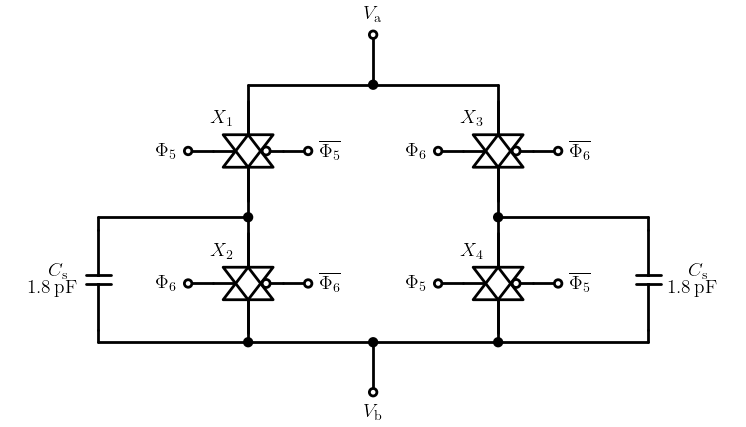

In [99]:
# Draw SC Bias Resistor
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})
import schemdraw as sd
from schemdraw import logic
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=14)
    
    # Va
    elm.Dot(open=True).label(r'$V_\mathrm{a}$', loc='top', ofst=0.15)
    elm.Line().down().length(1).dot()
    startDot = d.here
    d.push()

    # X1
    elm.Line().left().length(2.5)
    elm.Line().down().length(1)
    X1 = logic.Tgate().label('$X_1$', ofst=(-0.65, 0.4)).anchor('in1')
    elm.Line().at(X1.c).left().length(0.5)
    elm.Dot(open=True).label(r'$\Phi_{5}$', loc='left', ofst=0.15)
    elm.Line().at(X1.cbar).right().length(0.5)
    elm.Dot(open=True).label(r'$\overline{\Phi_{5}}$', loc='right', ofst=0.15)
    elm.Line().at(X1.out).down().length(1).dot()
    d.push()

    # Cs
    d.pop()
    d.push()
    elm.Line().left().length(3)
    elm.Line().down().length(0.25)
    elm.Capacitor().label(r'$C_\mathrm{s} \\$1.8\,pF', loc='top', ofst=0.15)
    elm.Line().down().length(0.25)
    bottomPoint = d.here
    elm.Line().right().tox(startDot)

    # X2
    d.pop()
    elm.Line().down().length(1)
    X2 = logic.Tgate().label('$X_2$', ofst=(-0.65, 0.4)).anchor('in1')
    elm.Line().at(X2.c).left().length(0.5)
    elm.Dot(open=True).label(r'$\Phi_{6}$', loc='left', ofst=0.15)
    elm.Line().at(X2.cbar).right().length(0.5)
    elm.Dot(open=True).label(r'$\overline{\Phi_{6}}$', loc='right', ofst=0.15)
    elm.Line().at(X2.out).down().toy(bottomPoint).dot()

    d.pop()

    # X3
    elm.Line().right().length(2.5)
    elm.Line().down().length(1)
    X3 = logic.Tgate().label('$X_3$', ofst=(-0.65, 0.4)).anchor('in1')
    elm.Line().at(X3.c).left().length(0.5)
    elm.Dot(open=True).label(r'$\Phi_{6}$', loc='left', ofst=0.15)
    elm.Line().at(X3.cbar).right().length(0.5)
    elm.Dot(open=True).label(r'$\overline{\Phi_{6}}$', loc='right', ofst=0.15)
    elm.Line().at(X3.out).down().length(1).dot()
    d.push()

    # Cs
    d.pop()
    d.push()
    elm.Line().right().length(3)
    elm.Line().down().length(0.25)
    elm.Capacitor().label(r'$C_\mathrm{s} \\$1.8\,pF', loc='bottom', ofst=0.15)
    elm.Line().down().length(0.25)
    bottomPoint = d.here
    elm.Line().left().tox(startDot).dot()

    # Vb
    elm.Line().down().length(1)
    elm.Dot(open=True).label(r'$V_\mathrm{b}$', loc='bottom', ofst=0.15)

    # X4
    d.pop()
    elm.Line().down().length(1)
    X4 = logic.Tgate().label('$X_4$', ofst=(-0.65, 0.4)).anchor('in1')
    elm.Line().at(X4.c).left().length(0.5)
    elm.Dot(open=True).label(r'$\Phi_{5}$', loc='left', ofst=0.15)
    elm.Line().at(X4.cbar).right().length(0.5)
    elm.Dot(open=True).label(r'$\overline{\Phi_{5}}$', loc='right', ofst=0.15)
    elm.Line().at(X4.out).down().toy(bottomPoint).dot()

    # Save the schematic
    d.save('figures/bias_circuit/sc_bias_resistor_circuit.svg')
    d.save('figures/bias_circuit/sc_bias_resistor_circuit.pdf')

In [100]:
# Switched-Capacitor Bias Resistor
# --> Since the nA currents would require area-consuming >1 MΩ-sized resistors, a switched-capacitor equivalent is used instead. 
# --> This configuration equals two parallel connected SC resistor equivalents.
# --> The bias current and gm can be adjusted with different clock frequencies. 
# --> By changing the bias current and gm, the bio-signal amplifier's transit frequency and gain can be adjusted.
# --> The antiparallel configuration simultaneously lowers switching transients and 
# effectively doubles the switching frequency at the output, which can be filtered out more easily.
# --> The remaining ripple voltage caused by the switched-capacitor implementation is suppressed 
# by additional decoupling capacitors (PMOS or MIM).

# This SC resistor is only implemented for the best bias circuit (version 4) to simplify the simulation for version 1 to 3.
# In fact, version 4 is just version 2 / 3 with switched capacitor implementation.
f_phi_bias = 62500
print('f_phi_bias =', round(float(f_phi_bias), 2), 'Hz')

R_1_bias = 3.72e6
print('R_1_bias =', round(float(R_1_bias) * 1e-6, 2), 'MOhm')

# Calculate capacitance for SC implementation
# Derivation over charge can be found in the appendix of the Master Thesis.
C_1_bias = 1 / (2 * f_phi_bias * R_1_bias)
print('C_1_bias =', round(float(C_1_bias) * 1e12, 2), 'pF')

f_phi_bias = 62500.0 Hz
R_1_bias = 3.72 MOhm
C_1_bias = 2.15 pF


Simulation

In [101]:
# The SC resistor is decoupled with an additional MDEC3 to decrease the switching transients.
# After several simulations, it turned out, that C_1_bias = 1.80pF and MDEC3 = 43u/40u are required for a 10nA output current.
# Since MDEC3 loads the SC resistor, C_1_bias deviates slightly from the calculated value.
C_1_bias = 1.8e-12
print('C_1_bias =', round(float(C_1_bias) * 1e12, 2), 'pF')

w_dec3 = 43.0
l_dec3 = 40.0
print('MDEC3: W =', round(w_dec3, 1), 'um, L =', l_dec3, 'um \n')

print('Beta-multiplier circuit with SC resistor performance summary:')
print('-----------------------------------------------')
print('Start-up settling time ~', round(500, 2), 'us (99% of nominal Ix = 9.9nA)')
# The other values are almost equal with version 2.

# In the Master Thesis the most important parameters (PSRR, pA/V, ppm/°C, transient, .op, dc, etc.) are plotted and compared for all four versions. 
# All design parameters like W/L ratios and capacitor values are summarized in tables.

C_1_bias = 1.8 pF
MDEC3: W = 43.0 um, L = 40.0 um 

Beta-multiplier circuit with SC resistor performance summary:
-----------------------------------------------
Start-up settling time ~ 500 us (99% of nominal Ix = 9.9nA)


## Further possible improvements

In [102]:
# Process Compensation:
# [Fath] uses an additional diode-connected NMOS in the opposite branch of the resistor and $K = 1$. 
# With that change, the reference current gets CTAT instead of PTAT behavior and might work better for certain applications.
# Furthermore, if the Vgs of this diode-connected NMOS is taken as the new reference voltage, process variants can be reduced since the parameters of a transistor are better controllable than those of a resistor.
# Since the mirror transistors M8, M9 and M14 in the amplifier core are directly connected to Vbias, the additional voltage drop across this NMOS would change the mirrored current significantly. 
# Therefore, the circuit must be flipped horizontally, connecting the resistor and a diode-connected PMOS to VDD.

# Temperature Compensation:
# Keep in mind that all circuits from above do not have built-in temperature compensation and therefore have rather high ppm/°C. 
# Of course, temperature compensation could be done with the well-known method of using PNP bipolar junction transistors (BJTs). 
# \cite{Osipov_2017_Temp_Comp_BMR} shows how a BMR can be temperature compensated with $N$ PMOS in the resistor branch and one PMOS in the opposite branch. 
# However, temperature compensation is not the biggest problem, as bio-signal applications are often mounted close to the body and thus temperature variations are not as high as in industrial or military applications.